In [1]:
import numpy as np
# import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, Booster
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import torch
import torch.nn.functional as F

from torchvision import datasets, transforms
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import cv2
from typing import List, Callable
from torch.utils.data import Dataset, DataLoader
from icecream import ic
from scipy.fftpack import dct
from sklearn.metrics import confusion_matrix

In [2]:
xgb.set_config(verbosity=2)
xgb.get_config()

{'use_rmm': False, 'verbosity': 2}

In [3]:
x = np.array([-2.0,2.0])
lr = .001
def grad_x(x): # f(x) = x**4
    return 4*x**3

step =  lr*grad_x(x)
x_2 =  x - step

d2 = grad_x(x_2) - grad_x(x)
d2x = - step
d2/d2x ,d2, step , x_2 , 12*x**2 , -(grad_x(x_2)/(- grad_x(x))+1)/lr

(array([47.236096, 47.236096]),
 array([ 1.51155507, -1.51155507]),
 array([-0.032,  0.032]),
 array([-1.968,  1.968]),
 array([48., 48.]),
 array([-47.236096, -47.236096]))

In [4]:
class MNIST_Seq(Dataset):
    """Sequenced CIFAR dataset."""

    def __init__(self, dataset, positional_encoding_size = 10, transform=None):
        """
        Arguments:
            dataset   (Dataset): torch standard dataset with annotations.
            
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.patch_size = 4
        self.stride = 4
        self.scale = 1
        self.block_size = int(((28-self.patch_size)//self.stride +1 )**2)
        self.positional_encoding_size = positional_encoding_size
        
        self.dataset = dataset
        self.pos_encoding = getPositionEncoding(seq_len=self.block_size, d=positional_encoding_size, n=self.block_size)

        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def image2seq(self, im):
        seq = [(im[x:x+self.patch_size,y:y+self.patch_size]).flatten() /(255)*self.scale
               for x in range(0,im.shape[0]-self.patch_size+1,self.stride)
               for y in range(0,im.shape[1]-self.patch_size+1,self.stride)]
    
        return np.concatenate([np.stack(seq),self.pos_encoding] , axis = -1)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image , target = self.dataset[idx]
        label = target#0 if target == 3 else 1
        image_seq = self.image2seq(np.array(image))
        sample = {'image_seq': image_seq, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
# transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
#                                       # transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
#                                       # transforms.RandomRotation(10),     #Rotates the image to a specified angel
#                                       # transforms.RandomAffine(degrees=5,translate=(.1,.1), scale=(0.9,1.1)), #Performs actions like zooms, change shear angles.
#                                       transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01)
#                                ])
transform_train = None

In [6]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    # P = (((P + 1) / 2) * 255).astype(np.uint8) # normalized position
    return P

# positional_encoding_size = 10

# P = getPositionEncoding(seq_len=block_size, d=positional_encoding_size, n=block_size)

In [7]:
# CIFAR_Train = datasets.CIFAR10('./mnist' , download=False, transform=transform_train)
# CIFAR_Test = datasets.CIFAR10('./mnist' ,train=False, download=False)

Trainset = datasets.MNIST('./data' , download=True, transform=transform_train)
Testset = datasets.MNIST('./data' ,train=False, download=True)
ic(len(Trainset) , len(Testset))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 9912422/9912422 [00:40<00:00, 244772.08it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████| 28881/28881 [00:01<00:00, 20436.68it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 1648877/1648877 [00:05<00:00, 277167.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 2364175.82it/s]
ic| len(Trainset): 60000, len(Testset): 10000


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(60000, 10000)

In [8]:
MNIST_Seq_Train =  MNIST_Seq (Trainset)
MNIST_Seq_Test =  MNIST_Seq (Testset)

In [9]:
def vis(im,t):
    im = np.array(im)
    imax = plt.imshow(im)
    plt.title(Trainset.classes[t])
    imax.axes.set_axis_off()
    plt.show()
    patch_size = MNIST_Seq_Train.patch_size
    stride = MNIST_Seq_Train.stride
    tiles = [im[x:x+patch_size,y:y+patch_size] for x in range(0,im.shape[0]-patch_size+1,stride) for y in range(0,im.shape[1]-patch_size+1,stride)]
    feature_map_size = int((im.shape[0]-patch_size)/stride +1)
    fig, axs = plt.subplots(feature_map_size, feature_map_size)
    for i , p in enumerate(tiles) :
        axs[i//feature_map_size,i%feature_map_size].imshow(p , vmax=255,vmin=0)
        axs[i//feature_map_size,i%feature_map_size].set_axis_off()
        
    plt.subplots_adjust(wspace=-.7, hspace=.03)
    plt.show()
    print(len(tiles))
    print(list(range(0,im.shape[0]-patch_size+1,stride)))
    
    print(feature_map_size)
    # plt.hist(im.flatten())
    # plt.show()

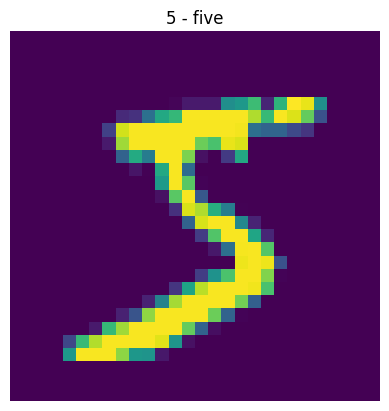

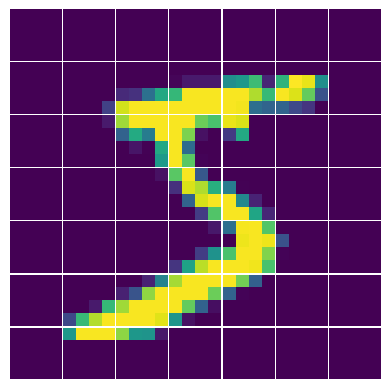

49
[0, 4, 8, 12, 16, 20, 24]
7


In [10]:
# only for visualization
for i in range(1):
    im ,t= Trainset[i]
    vis(im,t)


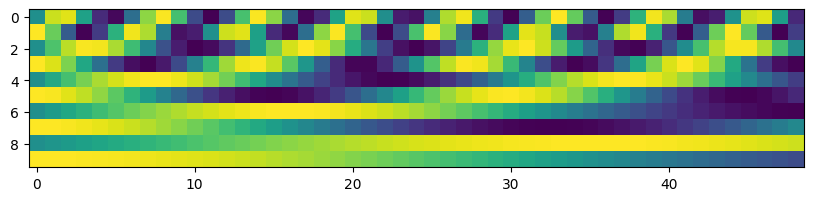

In [11]:
plt.figure(figsize=(10,3))
plt.imshow(MNIST_Seq_Train.pos_encoding.T)
plt.show()

ic| data_dict['image_seq'][:,:,:MNIST_Seq_Train.patch_size**2].max(): tensor(1., dtype=torch.float64)
ic| data_dict['image_seq'].shape: torch.Size([1000, 49, 26])
    data_dict['label'].shape: torch.Size([1000])


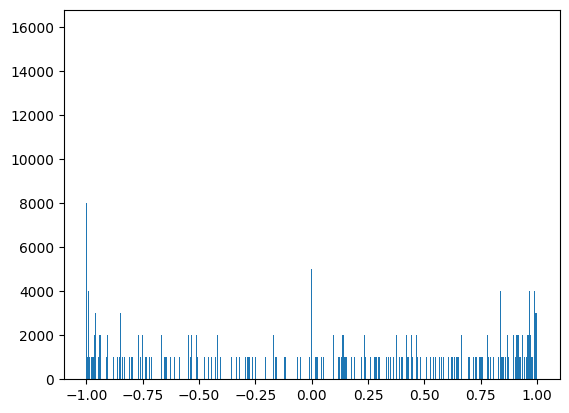

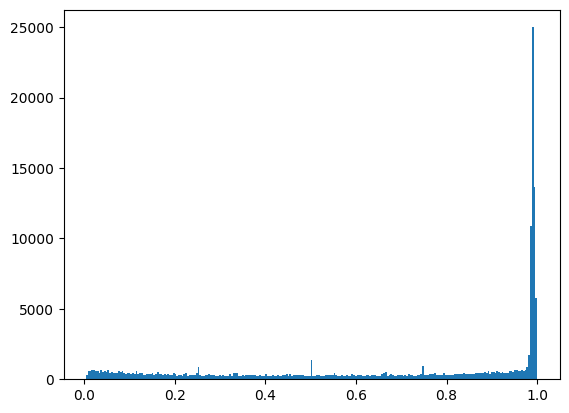

In [12]:
batch_size = 1000
TrainLoader = DataLoader(MNIST_Seq_Train,batch_size = batch_size ,num_workers=2, shuffle=True)
TestLoader = DataLoader(MNIST_Seq_Test,batch_size = batch_size)

itert = iter(TrainLoader)
data_dict =  next(itert)
ic(data_dict['image_seq'][:,:,:MNIST_Seq_Train.patch_size**2].max())
ic(data_dict['image_seq'].shape , data_dict['label'].shape)
a = plt.hist(data_dict['image_seq'][:,:,MNIST_Seq_Train.patch_size**2:].numpy().flatten() , bins=1000)
plt.show()
a = plt.hist(data_dict['image_seq'][:,:,:MNIST_Seq_Train.patch_size**2].numpy().flatten()[
             np.where(np.abs(data_dict['image_seq'][:,:,:MNIST_Seq_Train.patch_size**2].numpy().flatten())>0)],bins=255)
plt.show()


In [13]:
block_size = ic(MNIST_Seq_Train.block_size)
positional_encoding_size = ic(MNIST_Seq_Train.positional_encoding_size)


ic| MNIST_Seq_Train.block_size: 49
ic| MNIST_Seq_Train.positional_encoding_size: 10


In [14]:
embeding_dim =  50 # key , query size 
num_class  = 10
value_dim = 10
n_head = 1
input_dim =(MNIST_Seq_Train.patch_size**2) + MNIST_Seq_Train.positional_encoding_size 
flash = False

In [15]:
use_input = False
def base4kq(dt):
    input_array = dt.get_data().toarray()  #/255 -.5
    
    datak = np.pad(input_array, [(0,0),(embeding_dim, 0)], 'reflect') [:,:embeding_dim]
    # dataq = np.pad(input_array, [(0,0),(embeding_dim, 0)], 'reflect') [:,-embeding_dim:]
    return np.concatenate([datak,datak], axis=-1)

In [32]:

def obj_init(predicts, dtrain):
    ggrad = np.random.randn(*predicts.shape) #@+ggrad*.1
    ggrad = ggrad.flatten()
    hess = ggrad*0+0.001
    
    return ggrad, hess

key_query_param = {'max_depth':7, 'base_score':.0 , 'subsample': 1,
         'tree_method':'auto', 'multi_strategy': 'multi_output_tree',
         'min_child_weight' : .000,  # default=1
         'eta': 0.03, # default=.3
         'num_feature':input_dim,
         'num_class': embeding_dim,
            'lambda':1 } # default=1

value_param = {'max_depth':7, 'base_score':0 , 'subsample': 1,
         'tree_method':'auto', 'multi_strategy': 'multi_output_tree',
         'min_child_weight' : .000, # default=1
         'eta': 0.001, # default=.3
         'num_feature':input_dim,
         'num_class': value_dim,
              'lambda': 1} # default=1

key_booster = Booster(key_query_param)
query_booster = Booster(key_query_param)
value_booster = Booster(value_param)

for i, data in enumerate(TrainLoader):
    
    x , target = data['image_seq'] , data['label']
    model_XT = x.reshape(-1,input_dim)
    dtrain = xgb.DMatrix(model_XT.numpy())
    
    key_outputs = key_booster.predict(dtrain, output_margin=True)
    grad, hess = obj_init(key_outputs, dtrain)
    key_booster.boost(dtrain, grad, hess)
    
    query_outputs = query_booster.predict(dtrain, output_margin=True)
    grad, hess = obj_init(query_outputs, dtrain)
    query_booster.boost(dtrain, grad, hess)

    # value_outputs = value_booster.predict(dtrain, output_margin=True)
    # grad, hess = obj_init(value_outputs, dtrain)
    # value_booster.boost(dtrain, grad, hess)
    
    ic(i, grad.shape)
    if i >=4:
        break
    


ic| i: 0, grad.shape: (2450000,)
ic| i: 1, grad.shape: (2450000,)
ic| i: 2, grad.shape: (2450000,)
ic| i: 3, grad.shape: (2450000,)
ic| i: 4, grad.shape: (2450000,)


ic| out.shape: (49000, 50)


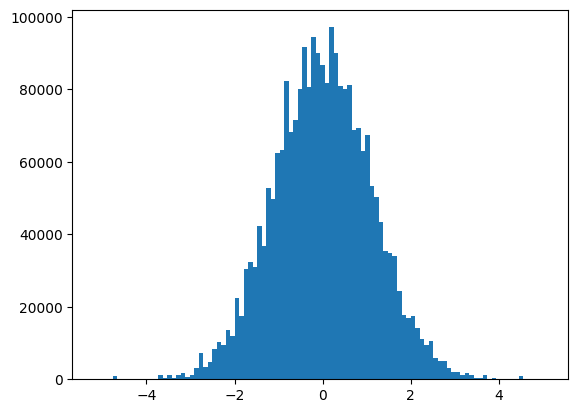

ic| out.shape: (49000, 50)


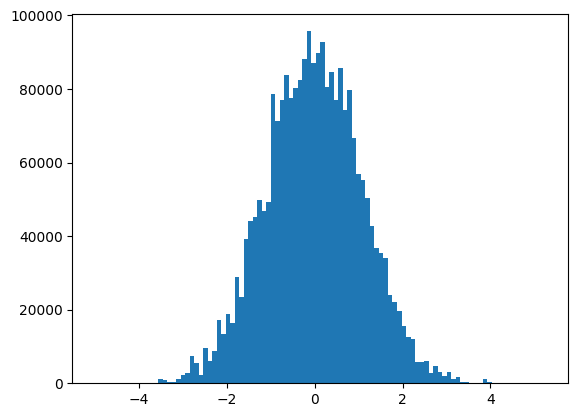

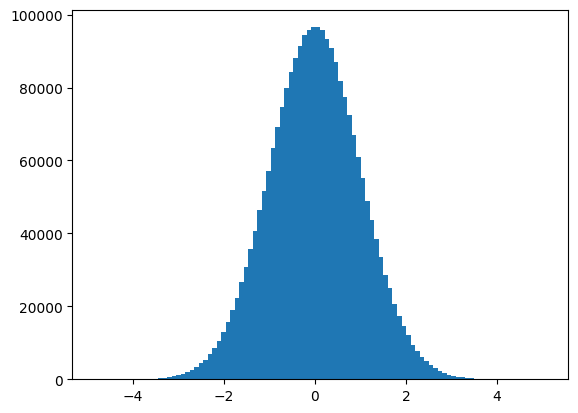

ic| out.shape: (49000, 10)


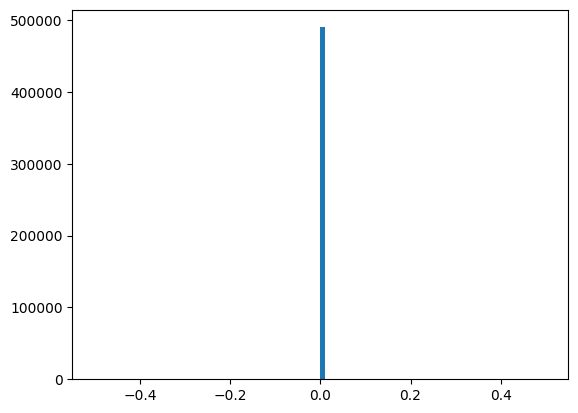

In [33]:
out = key_booster.predict(dtrain, output_margin=True)
ic(out.shape)
a = plt.hist(out.flatten(),bins =100)
plt.show()
out = query_booster.predict(dtrain, output_margin=True)
ic(out.shape)
a = plt.hist(out.flatten(),bins =100)
plt.show()
a = plt.hist(np.random.randn(*out.shape).flatten(),bins =100)
plt.show()
out = value_booster.predict(dtrain, output_margin=True)
ic(out.shape)
a = plt.hist(out.flatten(),bins =100)
plt.show()


# a = plt.hist(out[:,:value_dim].flatten(),bins =100)
# plt.show()

In [34]:
def predict_inner(key, query, value):

    values = value.reshape(-1,block_size,value_dim)
    keys = key.reshape(-1,block_size,embeding_dim)
    queries = query.reshape(-1,block_size, embeding_dim)
    
    B, T, C = keys.size()
    
    keys = keys.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    queries = queries.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
    values = values.view(B, T, n_head, value_dim // n_head).transpose(1, 2) # (B, nh, T, hs)

    
    if flash:
        # efficient attention using Flash Attention CUDA kernels
        each_head_y = F.scaled_dot_product_attention(queries, keys, values, attn_mask=None, dropout_p= 0, is_causal=False)
    else:
        # manual implementation of attention
        att = (queries @ keys.transpose(-2, -1)) * (1.0 / np.sqrt(keys.size(-1)))
        att = F.softmax(att, dim=-1)


        each_head_y = att  @ values  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        
    output_seq = each_head_y.transpose(1, 2).contiguous().view(B, T, value_dim) # re-assemble all head outputs side by side
    output = (output_seq[:,:,:]).sum(1)
    return output


def predict(key, query, value, has_grad = True):

    approx_hess = True
    
    key = key.copy()
    query = query.copy()
    value = value.copy()
    
    key = torch.from_numpy(key).float().requires_grad_(True)
    query = torch.from_numpy(query).float().requires_grad_(True)
    value = torch.from_numpy(value).float().requires_grad_(True)

    output = predict_inner(key, query, value)
    
    grad = {}
    grad2 = {}
    hess = {}
    if has_grad:
        loss = 0
        loss += F.cross_entropy(output ,target,reduction='sum', label_smoothing=0.00)
        r_loss = loss.item()
        loss.backward()
        # print(keys.grad)
        grad["key"] = key.grad.numpy().flatten() *1
        grad["query"] = query.grad.numpy().flatten() *1
        grad["value"] = value.grad.numpy().flatten() *1
        

        if approx_hess:
            with torch.no_grad():
                key.data.add_(-0.01*key.grad)
                key.grad.zero_()
                query.data.add_(-0.01*query.grad)
                query.grad.zero_()
                value.data.add_(-0.01*value.grad)
                value.grad.zero_()

            output = predict_inner(key, query, value)
            loss = 0
            loss += F.cross_entropy(output ,target,reduction='sum', label_smoothing=0.00)
            loss.backward()

            grad2["key"] = key.grad.numpy().flatten()
            grad2["query"] = query.grad.numpy().flatten()
            grad2["value"] = value.grad.numpy().flatten()
            
            hess["key"] =  0.01* ((grad2["key"]     - grad["key"])/(- 0.01*grad["key"] - 
                                                               (2*(grad["key"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)
            hess["query"] = 0.01*((grad2["query"] - grad["query"])/(- 0.01*grad["query"]- 
                                                               (2*(grad["query"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)
            hess["value"] = 0.01*((grad2["value"] - grad["value"])/(- 0.01*grad["value"]- 
                                                               (2*(grad["value"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)
        
        return output, grad, hess, r_loss
        
    return output

In [35]:
# hess["key"] =   .1*((grad2["key"]     - grad["key"])/(- 0.01*grad["key"] - 
#                                                                (2*(grad["key"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)
#             hess["query"] = .1*((grad2["query"] - grad["query"])/(- 0.01*grad["query"]- 
#                                                                (2*(grad["query"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)
#             hess["value"] = .1*((grad2["value"] - grad["value"])/(- 0.01*grad["value"]- 
#                                                                (2*(grad["value"] >= 0) - 1)*1e-6)).clip(min=1e-6,max=100)

In [36]:
            # hess["key"] =   ((grad2["key"]     - grad["key"])/(- 0.01*grad["key"] - 
            #                                                    (np.sign(grad["key"]))*1e-2)).clip(min=1e-6,max=100)
            # hess["query"] = ((grad2["query"] - grad["query"])/(- 0.01*grad["query"]- 
            #                                                    (np.sign(grad["query"]))*1e-2)).clip(min=1e-6,max=100)
            # hess["value"] = ((grad2["value"] - grad["value"])/(- 0.01*grad["value"]- 
            #                                                    (np.sign(grad["value"]))*1e-2)).clip(min=1e-6,max=100)

### INITIAL STATE

In [37]:
b = 0
all_test_preds = []
all_test_labels = []
all_model_outputs = []

for i, data in enumerate(TestLoader):
    print(i)
    x , target = data['image_seq'] , data['label']
    model_XT = x.reshape(-1,input_dim)
    
    dtrain = xgb.DMatrix(model_XT.numpy())
    
    key = key_booster.predict(dtrain, output_margin=True)
    query = query_booster.predict(dtrain, output_margin=True)
    value = value_booster.predict(dtrain, output_margin=True)
    with torch.no_grad():
        predicts = predict(key, query, value, has_grad=False)
    all_model_outputs.append(np.concatenate([value, key, query], axis=-1))
    yhat = predicts.argmax(dim=-1).numpy()
    all_test_preds.append(yhat)
    all_test_labels.append(target.numpy())
    break


preds = np.concatenate(all_test_preds)
labels = np.concatenate(all_test_labels)
model_outputs_test = np.concatenate(all_model_outputs)

0


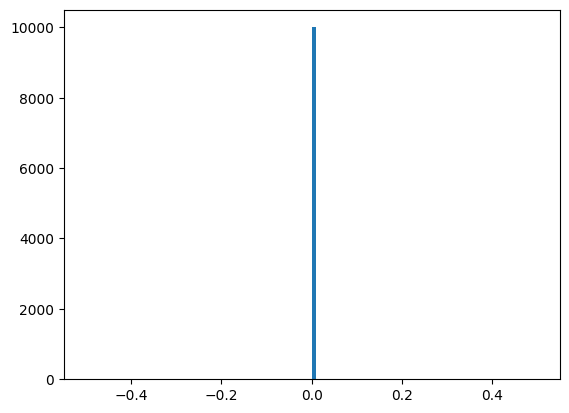

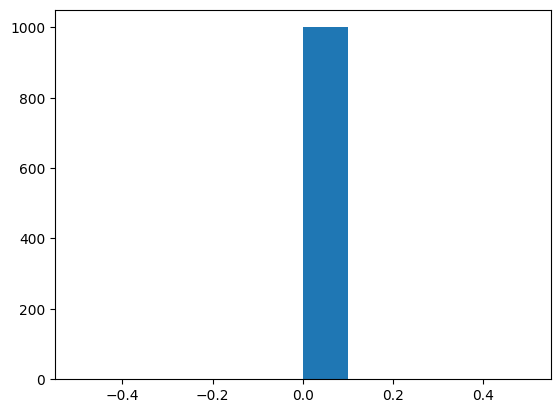

In [38]:
a = plt.hist(predicts.flatten(),bins =100)
plt.show()
a = plt.hist(yhat.flatten(),bins =10)
plt.show()

In [39]:
t=10

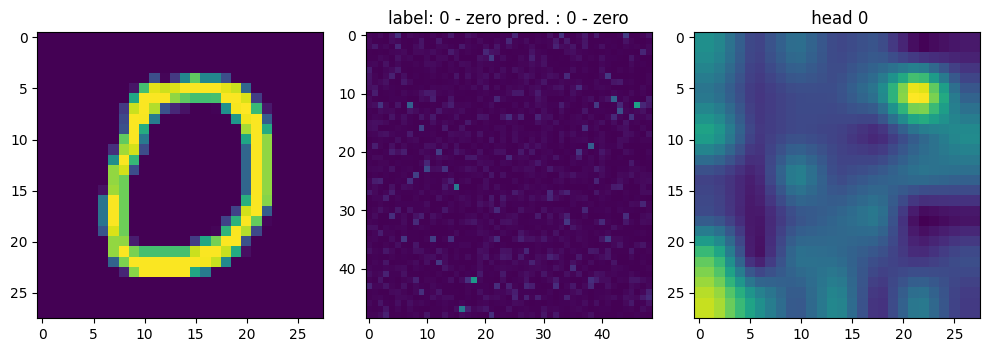

ic| t: 10


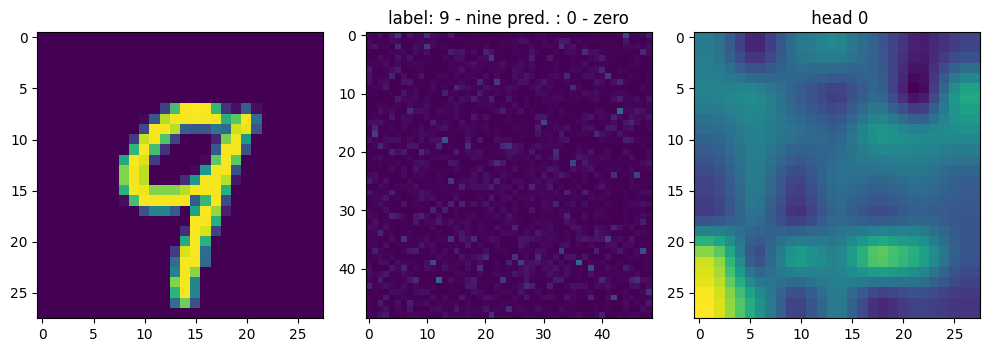

ic| t: 12


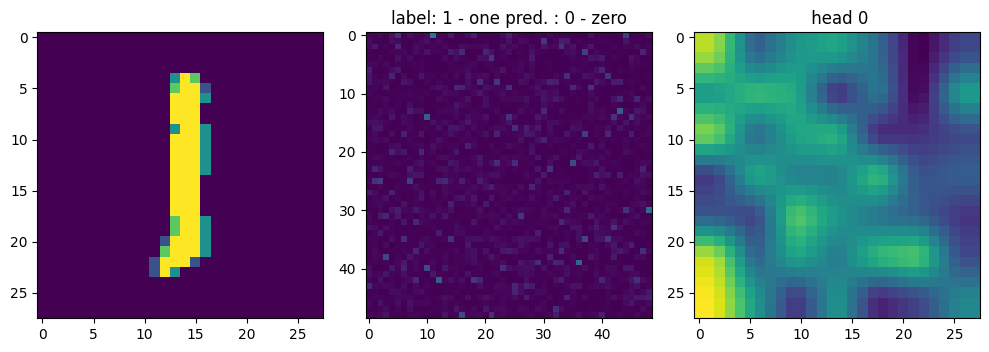

ic| t: 14


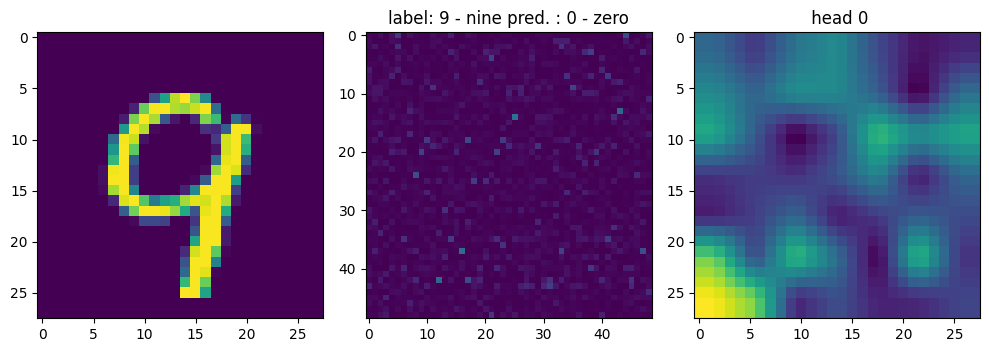

ic| t: 16


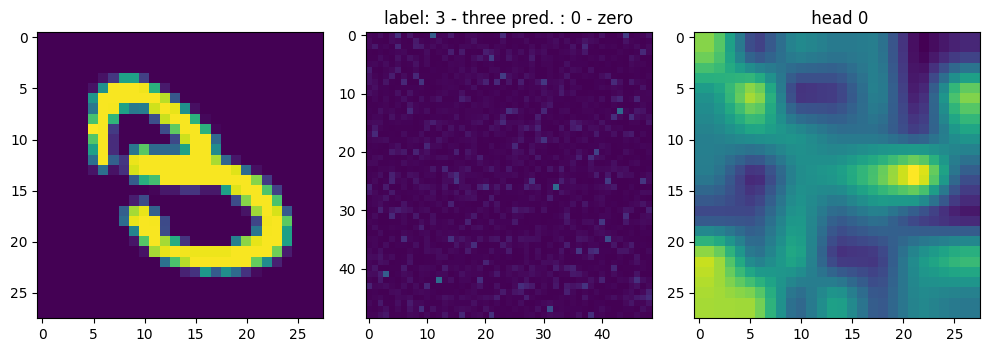

ic| t: 18


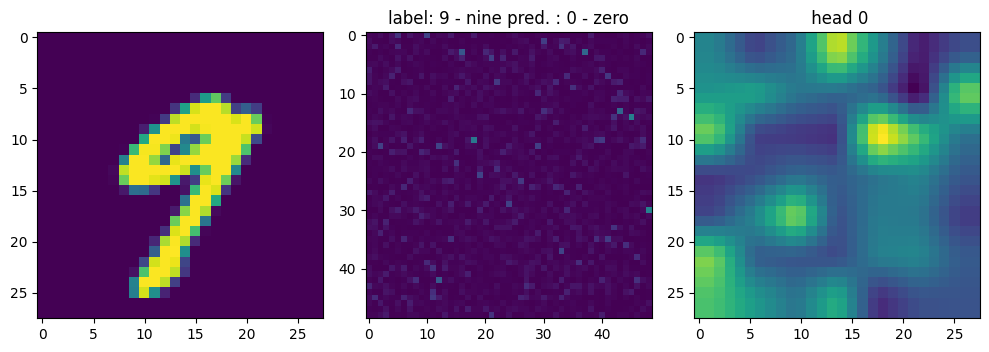

ic| t: 20


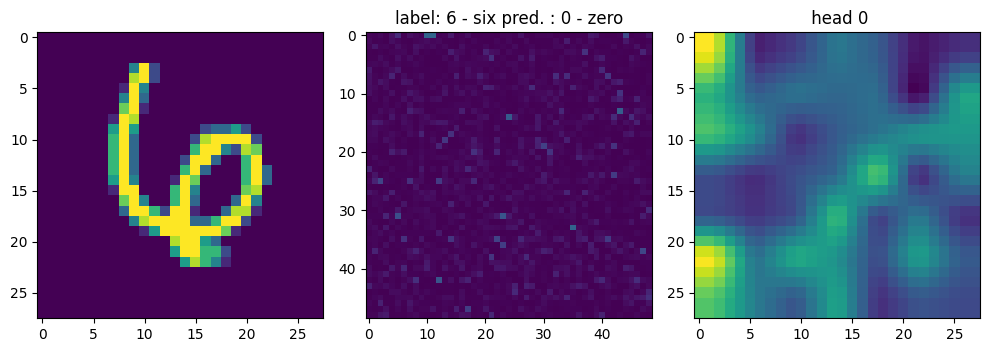

ic| t: 22


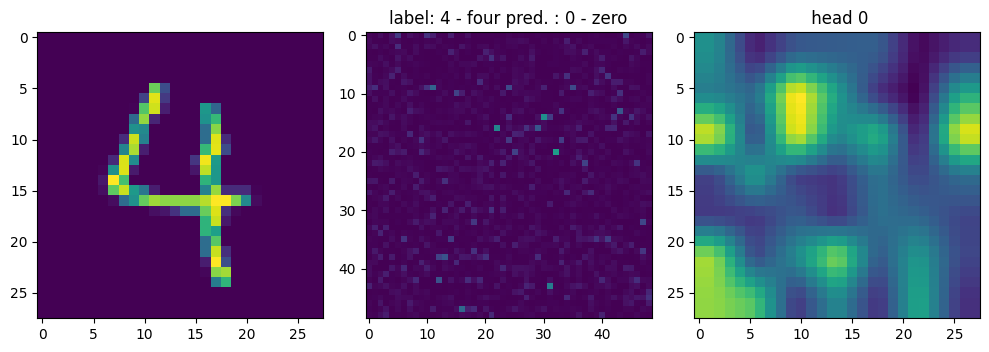

ic| t: 24


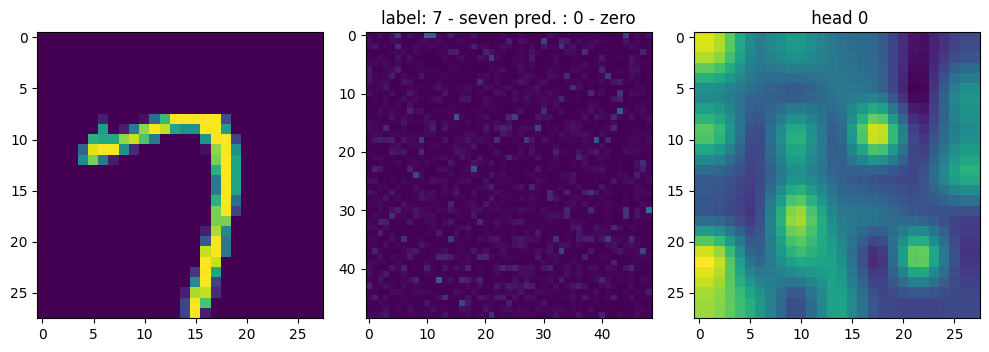

ic| t: 26


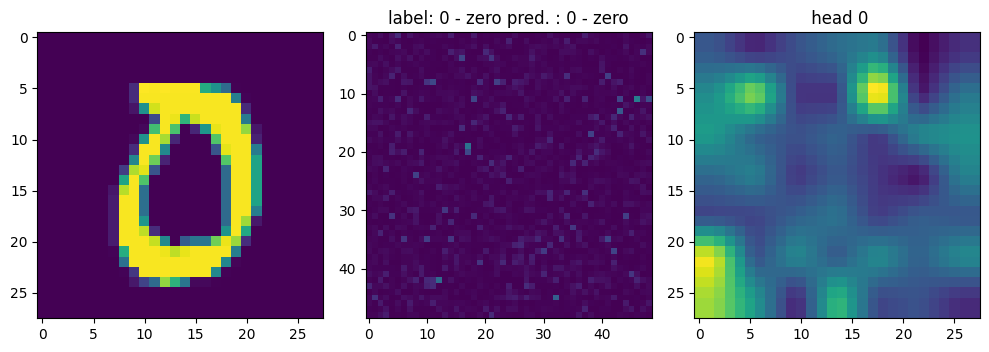

ic| t: 28


In [40]:
for c in range(10):
    
    if True:
        
        if n_head == 1:
            fig, axes = plt.subplots(1,3 , figsize=(10,7))
            axes = axes[None]
        else:
            fig, axes = plt.subplots(n_head,3 , figsize=(10,n_head*3))
        
        
        with torch.no_grad():
            pred0 = model_outputs_test[t*block_size:t*block_size + block_size]
#             pred0.shape
        pred0 = pred0.copy()
        
        pred0 = torch.from_numpy(pred0).float().requires_grad_(False)
        with torch.no_grad():
            values = pred0[:, :value_dim].reshape(-1,block_size,value_dim)
    
            keys = pred0[:, value_dim: value_dim + embeding_dim].reshape(-1,block_size,embeding_dim)
            queries = pred0[:, value_dim + embeding_dim:value_dim + 2*embeding_dim] .reshape(-1,block_size, embeding_dim)
            B, T, C = keys.size()
            
            keys = keys.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
            queries = queries.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
            values = values.view(B, T, n_head, value_dim // n_head).transpose(1, 2) # (B, nh, T, hs)
    
            if False:
                # efficient attention using Flash Attention CUDA kernels
                y = torch.nn.functional.scaled_dot_product_attention(queries, keys, values)
            else:
                # manual implementation of attention
                att = (queries @ keys.transpose(-2, -1)) * (1.0 / np.sqrt(keys.size(-1)))
                # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf')) # causal implementation 
                att = F.softmax(att, dim=-1)
                # att = F.relu(att)
                y = att @ values  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
            output_seq = y.transpose(1, 2).contiguous().view(B, T, value_dim) # re-assemble all head outputs side by side
            output = (output_seq[:,:,:]).sum(1) #
            # ic(F.softmax(output,dim=-1))
            for i, head in enumerate(att[0]):
                axes[i,0].imshow(Testset.data[t])
                
                axes[i,1].imshow(head.T,vmin=0, vmax=1)
                # axes[i,1].imshow(F.relu(head.T),vmin=0)
                # axes[i,1].imshow(head.T)
                tttt = Testset.classes[preds[t]]
                axes[i,1].set_title('label: ' + str(Testset.classes[Testset.targets[t]]) + ' pred. : ' +  tttt )
                # plt.show()
                attention_mask = head.sum(0).reshape(int(block_size**.5),int(block_size**.5)).numpy()
    #             print( att.sum(0))
                image = cv2.resize(attention_mask, (28, 28))
                # ic(image)
                axes[i,2].imshow(image)
                axes[i,2].set_title(f' head {i}')
        #         axes[2].imshow(attention_mask)
    
        #         axes[2].imshow(att.sum(0).reshape(int(len(tiles)**.5),int(len(tiles)**.5)), interpolation="bicubic")
            fig.tight_layout()   
            plt.show()
    
    ic(t)
    t+=2

In [41]:
key_query_param = {'max_depth':9, 'base_score':.0,
         'tree_method':'hist', 'multi_strategy': 'multi_output_tree',
         'eta': .3,
         'num_feature':input_dim,
         'num_class': embeding_dim,
         'lambda':10 } # default=1

value_param = {'max_depth':9, 'base_score':.0,
         'tree_method':'hist', 'multi_strategy': 'multi_output_tree',
         'eta': .03,
         'num_feature':input_dim,
         'num_class': value_dim,
         'lambda':1 } # default=1


#grow_policy [default= depthwise]

# key_query_param = {'max_depth':7, 'base_score':.0 , 'subsample': 1,
#          'tree_method':'auto', 'multi_strategy': 'multi_output_tree',
#          'min_child_weight' : .000,  # default=1
#          'eta': 0.03, # default=.3
#          'num_feature':input_dim,
#          'num_class': embeding_dim,
#             'lambda':1 } # default=1

# value_param = {'max_depth':7, 'base_score':0 , 'subsample': 1,
#          'tree_method':'auto', 'multi_strategy': 'multi_output_tree',
#          'min_child_weight' : .000, # default=1
#          'eta': 0.03, # default=.3
#          'num_feature':input_dim,
#          'num_class': value_dim,
#               'lambda': 1} # default=1

key_booster.set_param(key_query_param)
query_booster.set_param(key_query_param)
value_booster.set_param(value_param)

it = 0


In [42]:
def plot():
    print('\n ############# grad \n')
    a = plt.hist(grad['key'].clip(min=-.05,max=.05),bins =1000, log=True)
    plt.title('key grad')
    plt.show()
    a = plt.hist(grad['query'].clip(min=-.05,max=.05),bins =1000, log=True)
    plt.title('query grad')
    plt.show()
    a = plt.hist(grad['value'].clip(min=-1,max=1),bins =1000, log=True)
    plt.title('value grad')
    plt.show()
    print('hist \n')
    a = plt.hist(hess['key'],bins =100)
    plt.title('key hess')
    plt.show()
    a = plt.hist(hess['query'],bins =100)
    plt.title('query hess')
    plt.show()
    a = plt.hist(hess['value'],bins =100)
    plt.title('value hess')
    plt.show()
    
    a = plt.hist(key.flatten(),bins =1000)
    plt.title('key')
    plt.show()
    
    a = plt.hist(query.flatten(),bins =1000)
    plt.title('query')
    plt.show()
    
    a = plt.hist(value.flatten(),bins =1000)
    plt.title('value')
    plt.show()

iteration 1 2.302585205078125
iteration 2 1.6098575439453124
iteration 3 1.2988125
iteration 4 1.0796748046875
iteration 5 0.9567313232421875
iteration 6 0.8480654907226562

 ############# grad 



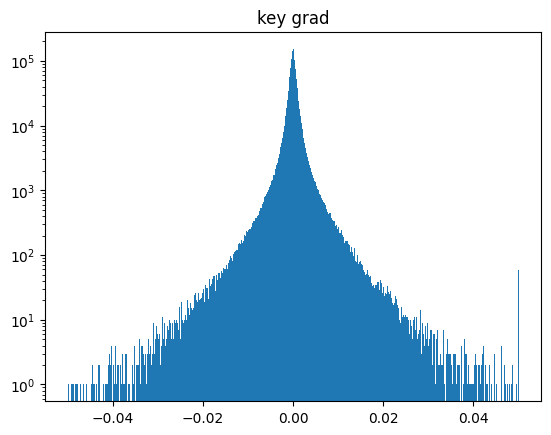

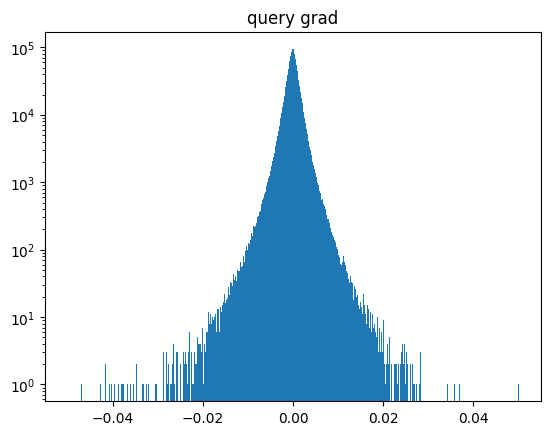

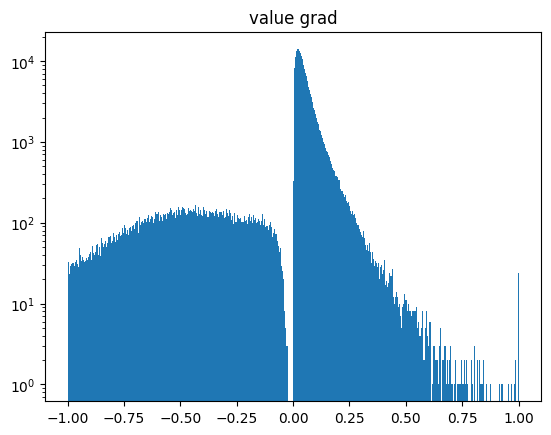

hist 



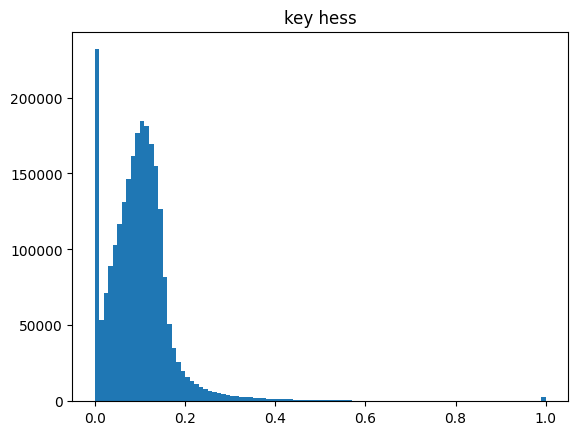

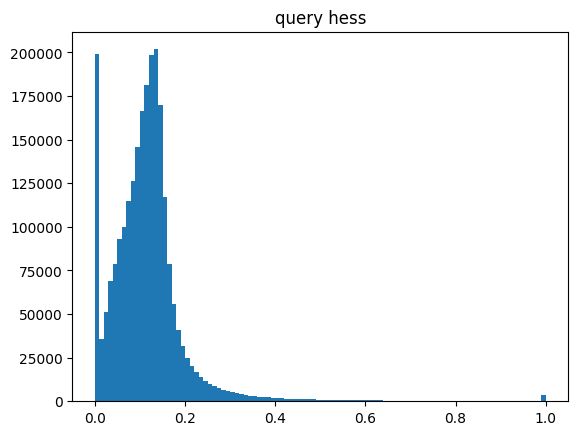

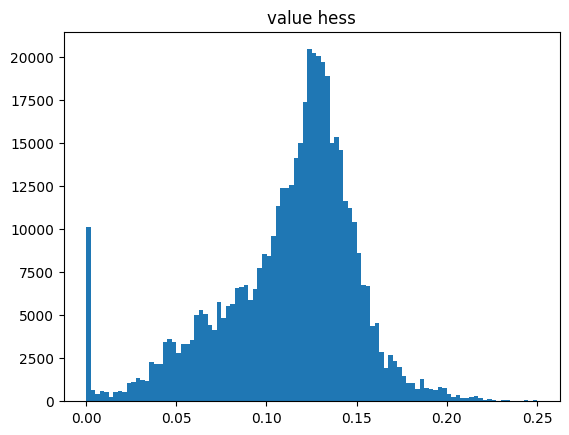

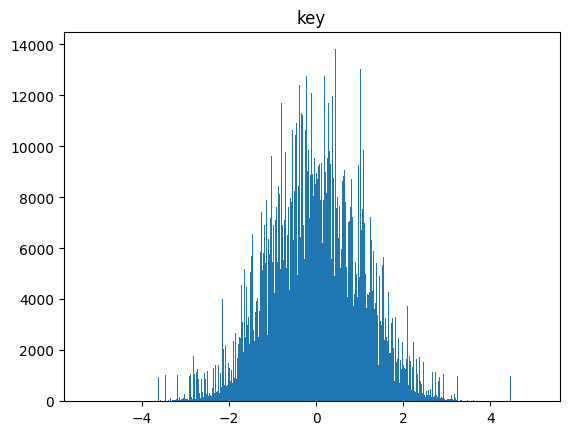

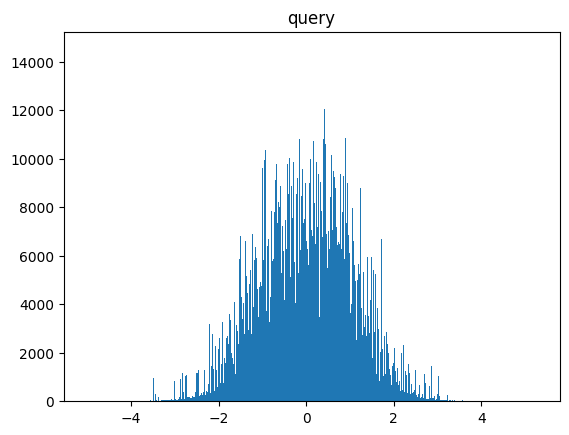

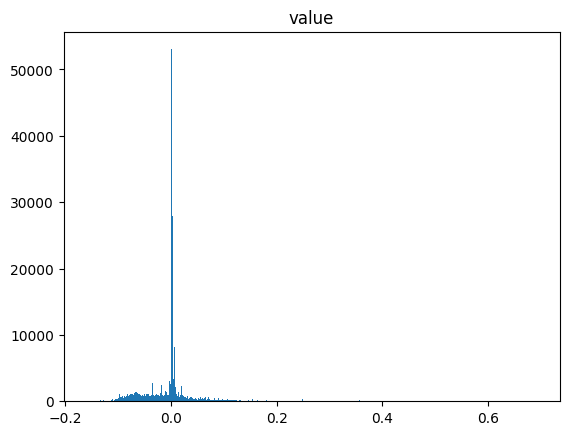

iteration 7 0.7881131591796875
iteration 8 0.7517306518554687
iteration 9 0.7182540893554688
iteration 10 0.6460005493164063
iteration 11 0.5723624877929687
iteration 12 0.571025146484375
iteration 13 0.5460693359375
iteration 14 0.5201014404296875
iteration 15 0.4968219604492187
iteration 16 0.49591177368164063
iteration 17 0.4996837158203125
iteration 18 0.4689778747558594
iteration 19 0.4476366271972656
iteration 20 0.48622332763671877
iteration 21 0.4661827392578125
iteration 22 0.4288028564453125
iteration 23 0.4309556884765625
iteration 24 0.4083290100097656
iteration 25 0.4139259338378906
iteration 26 0.3778984985351562
iteration 27 0.40563479614257814
iteration 28 0.3819425048828125
iteration 29 0.37064715576171875
iteration 30 0.3812482604980469
iteration 31 0.35924029541015623
iteration 32 0.373418212890625
iteration 33 0.3611090393066406
iteration 34 0.35952276611328127
iteration 35 0.3428070068359375
iteration 36 0.35883584594726564
iteration 37 0.3546275634765625
iteration

KeyboardInterrupt: 

In [43]:
for epoch in range(10):
    for i, data in enumerate(TrainLoader):
        x , target = data['image_seq'] , data['label']
        model_XT = x.reshape(-1,input_dim)
        dtrain = xgb.DMatrix(model_XT.numpy())

        key = key_booster.predict(dtrain, output_margin=True)
        query = query_booster.predict(dtrain, output_margin=True)
        value = value_booster.predict(dtrain, output_margin=True)

        predicts, grad, hess, loss = predict(key, query, value)

        key_booster.boost(dtrain, grad["key"], hess["key"])
        query_booster.boost(dtrain, grad["query"], hess["query"])
        value_booster.boost(dtrain, grad["value"], hess["value"])
        it += 1
        print(f'iteration {it}' , loss/batch_size)
        if i == 5 :
            plot()
        # v_t = torch.zeros_like(torch.tensor(dummy_output))
        # m_t = torch.zeros_like(torch.tensor(dummy_output))
        
        
    # cm = test_cm()
    # t_cm = train_cm()


In [44]:
@torch.no_grad()
def confusion_score(dataloader):
    cm = None
    
    for i, data in enumerate(dataloader):
        x , target = data['image_seq'] , data['label']
        model_XT = x.reshape(-1,input_dim)
        dtrain = xgb.DMatrix(model_XT.numpy())

        key = key_booster.predict(dtrain, output_margin=True)
        query = query_booster.predict(dtrain, output_margin=True)
        value = value_booster.predict(dtrain, output_margin=True)
        predicts = predict(key, query, value, has_grad=False)
        yhat = predicts.argmax(dim=-1).numpy() 
        if cm is None:
            cm = confusion_matrix(target.numpy(),yhat)
        else:
            cm += confusion_matrix(target.numpy(),yhat)
    print('Acc.',cm.diagonal().sum()/len(dataloader.dataset)) 
    return cm


In [45]:
confusion_score(TrainLoader)

Acc. 0.9267833333333333


array([[5674,    1,   24,   14,   14,   23,   54,    9,  106,    4],
       [   0, 6574,   45,   16,   32,   15,   15,   17,   20,    8],
       [  48,   55, 5325,   98,   94,    8,   51,   94,  153,   32],
       [  11,   26,  112, 5526,    7,  135,   26,   82,  114,   92],
       [  16,   20,   18,    4, 5585,    3,   39,   12,   30,  115],
       [  22,   63,    9,  152,   30, 4957,   79,    8,   64,   37],
       [  50,   29,   30,   15,   49,   92, 5615,    1,   35,    2],
       [  24,   54,   70,   55,   95,    6,    0, 5773,   21,  167],
       [  17,   60,   53,   79,   44,  105,   30,   16, 5353,   94],
       [  43,   21,   30,   84,  229,   27,    8,  155,  127, 5225]])

In [46]:
confusion_score(TestLoader)

Acc. 0.9242


array([[ 953,    0,    3,    0,    0,    3,    5,    3,   11,    2],
       [   0, 1116,    3,    1,    2,    3,    5,    1,    4,    0],
       [  13,    6,  916,   22,   11,    0,    8,   17,   34,    5],
       [   4,    1,   16,  912,    3,   32,    3,   10,   19,   10],
       [   1,    4,    3,    1,  942,    0,    8,    0,    5,   18],
       [   6,    7,    1,   26,    5,  805,   15,    6,   18,    3],
       [  14,    4,    5,    2,   12,   21,  896,    0,    4,    0],
       [   2,   13,   20,    7,   10,    4,    2,  939,    5,   26],
       [   4,    3,    5,   24,   11,   13,   11,    7,  878,   18],
       [   9,    6,    1,   10,   55,    7,    2,   18,   16,  885]])

In [38]:
# ic(model.num_boosted_rounds())
# model.save_model('softmax-att.json')

In [32]:
b = 0
all_test_preds = []
all_test_labels = []
all_model_outputs = []

for i, data in enumerate(TestLoader):
    print(i)
    x , target = data['image_seq'] , data['label']
    model_XT = x.reshape(-1,input_dim)
    
    dtrain = xgb.DMatrix(model_XT.numpy())
    
    key = key_booster.predict(dtrain, output_margin=True)
    query = query_booster.predict(dtrain, output_margin=True)
    value = value_booster.predict(dtrain, output_margin=True)
    with torch.no_grad():
        predicts = predict(key, query, value, has_grad=False)
    all_model_outputs.append(np.concatenate([value, key, query], axis=-1))
    yhat = predicts.argmax(dim=-1).numpy()
    all_test_preds.append(yhat)
    all_test_labels.append(target.numpy())
    break


preds = np.concatenate(all_test_preds)
labels = np.concatenate(all_test_labels)
model_outputs_test = np.concatenate(all_model_outputs)

0


In [33]:
t=10

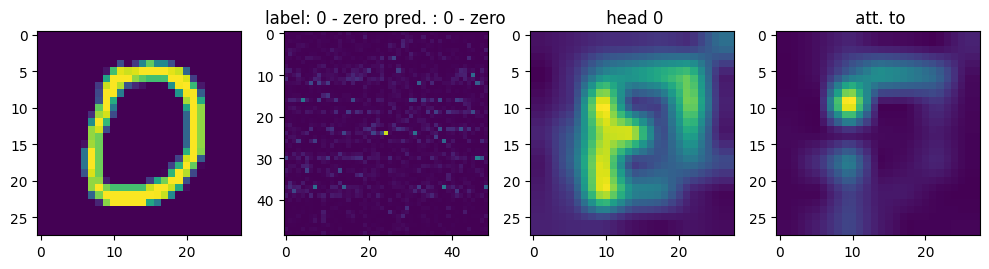

ic| t: 10


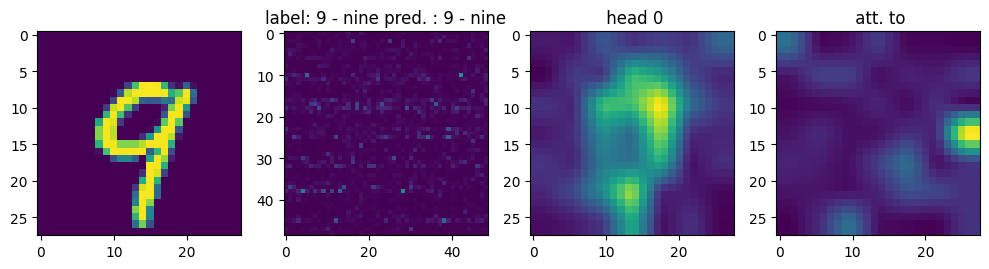

ic| t: 12


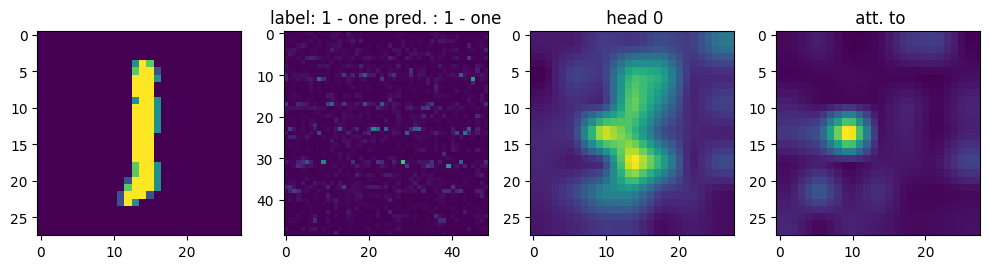

ic| t: 14


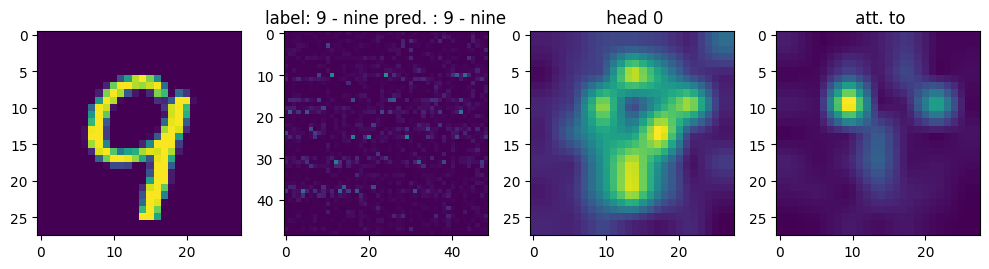

ic| t: 16


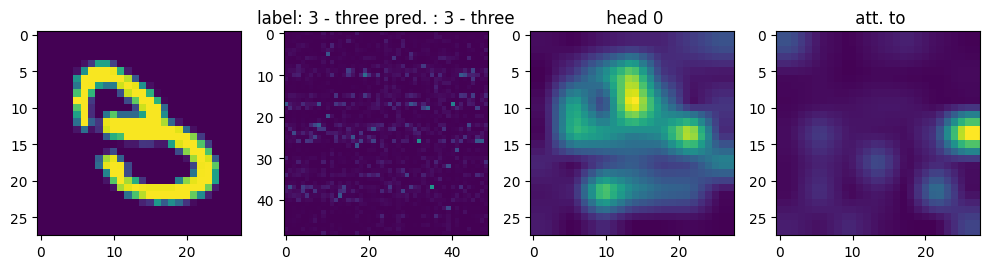

ic| t: 18


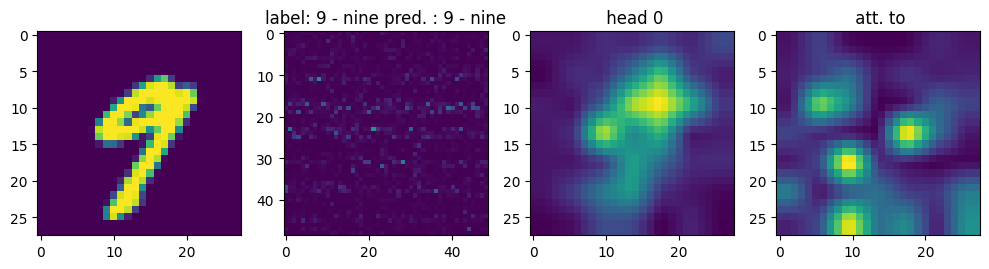

ic| t: 20


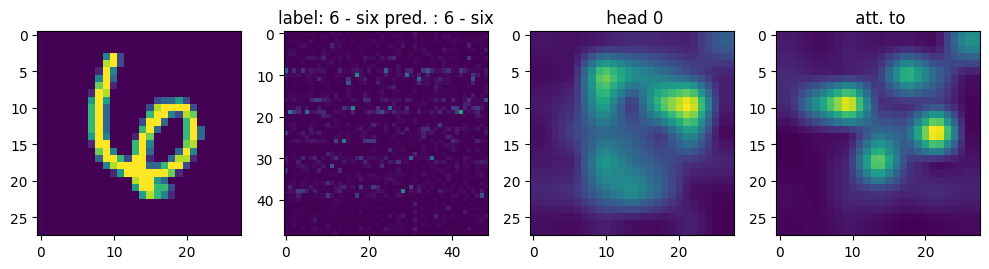

ic| t: 22


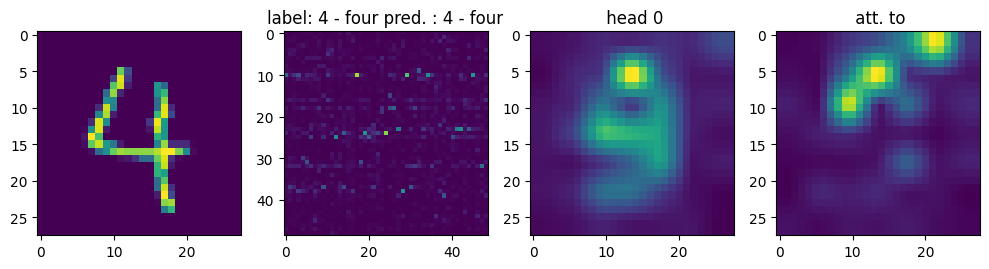

ic| t: 24


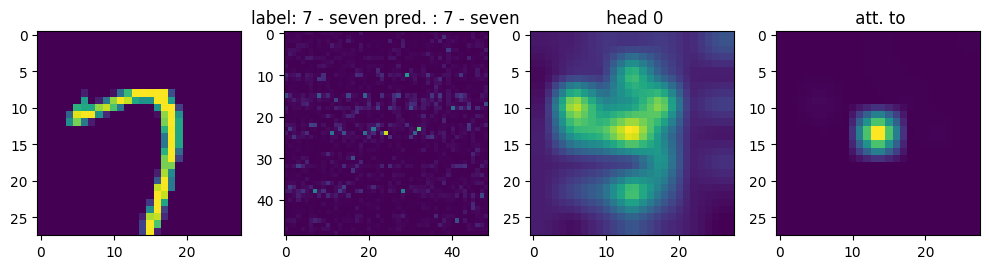

ic| t: 26


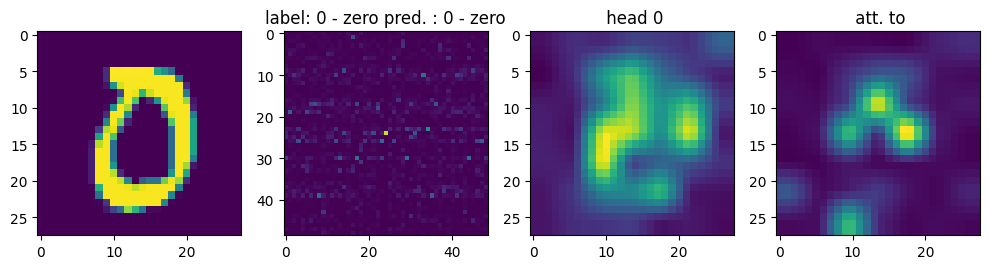

ic| t: 28


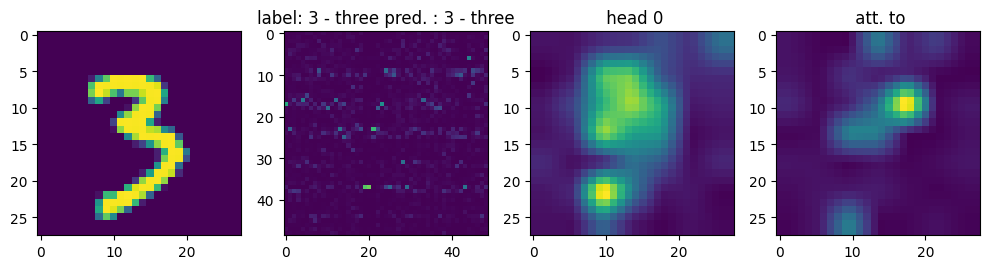

ic| t: 30


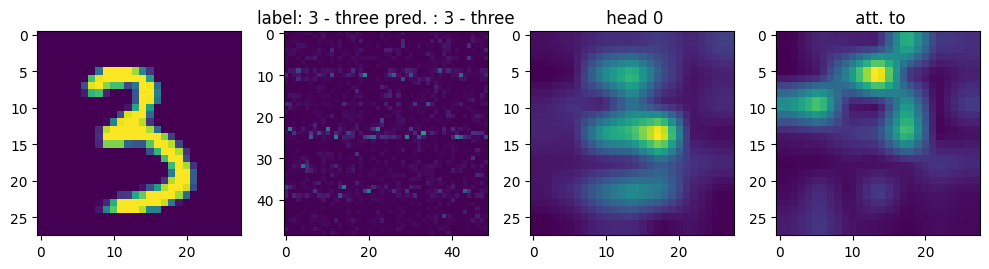

ic| t: 32


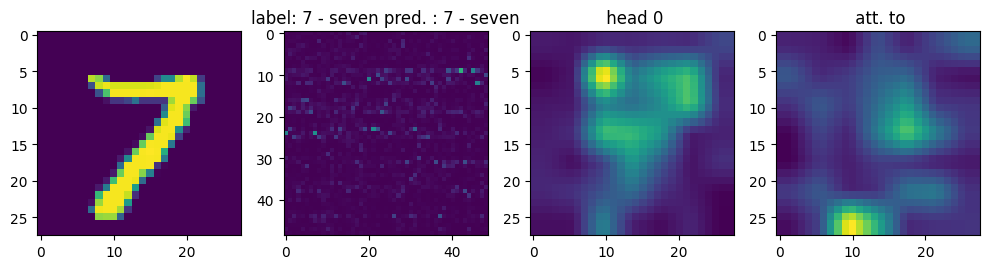

ic| t: 34


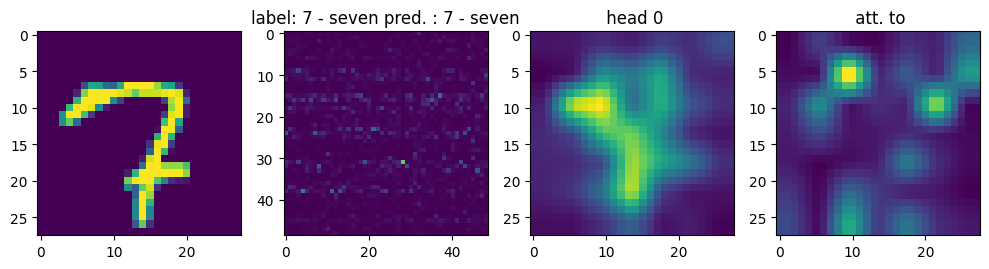

ic| t: 36


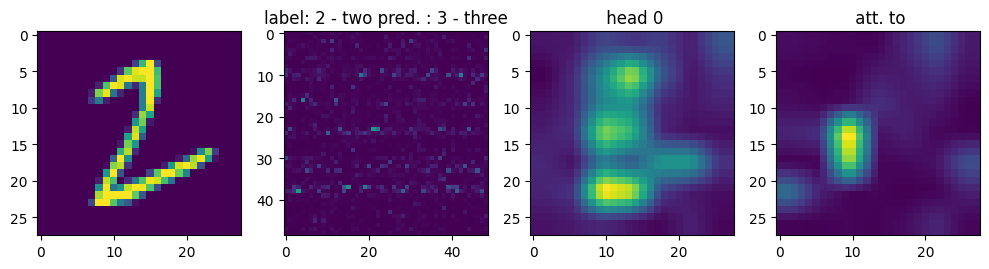

ic| t: 38


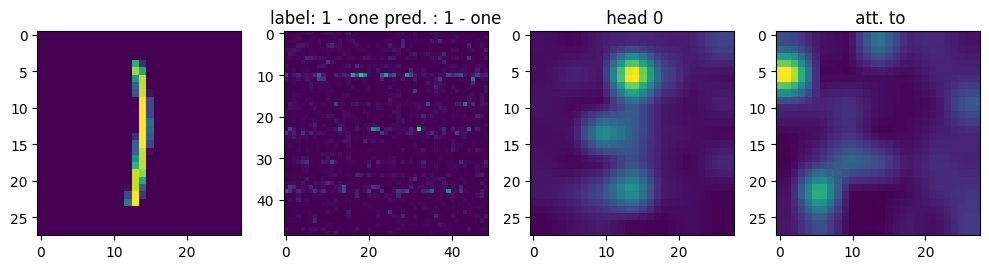

ic| t: 40


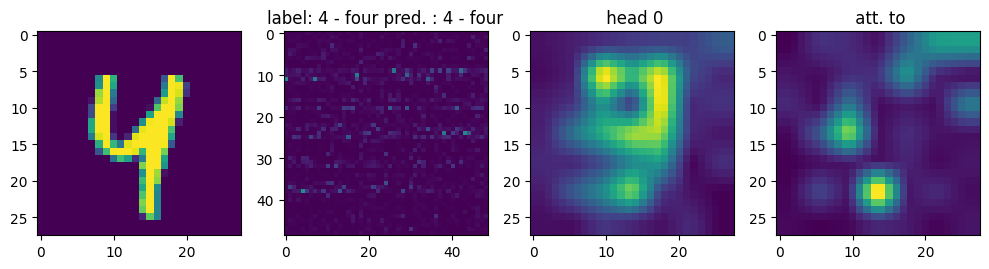

ic| t: 42


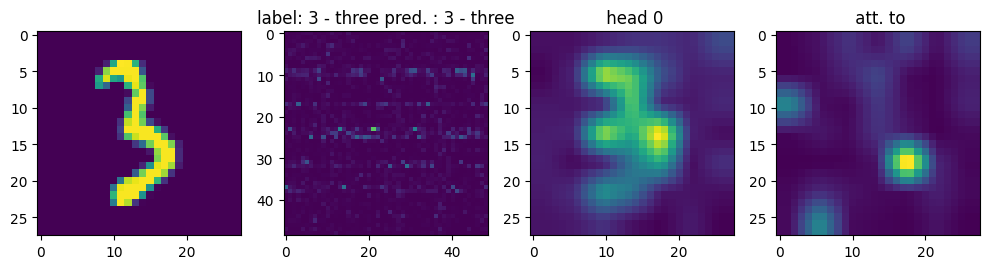

ic| t: 44


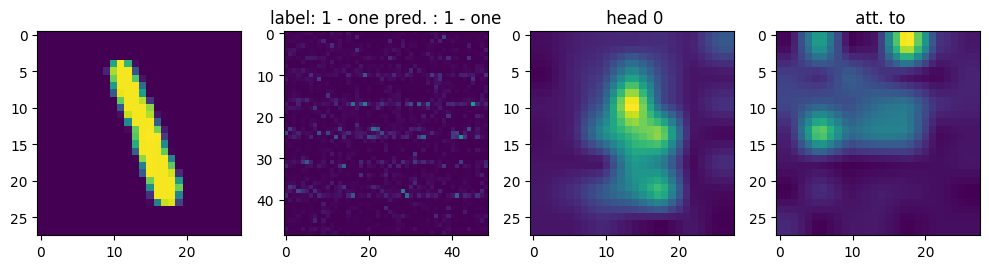

ic| t: 46


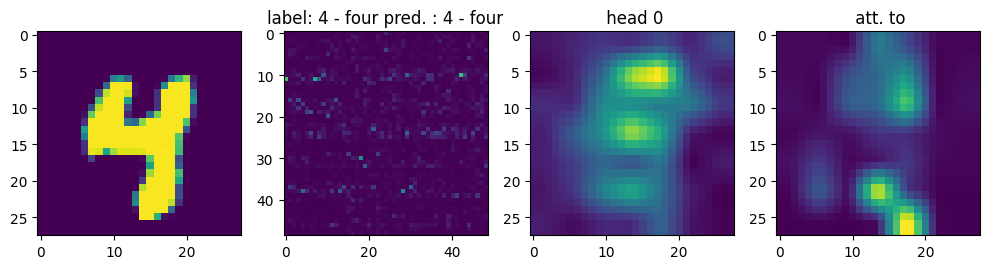

ic| t: 48


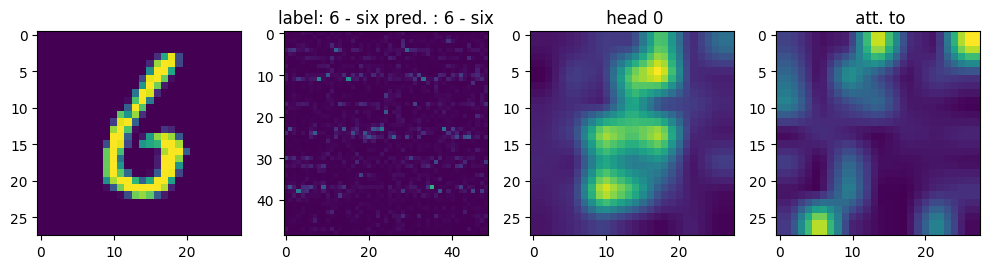

ic| t: 50


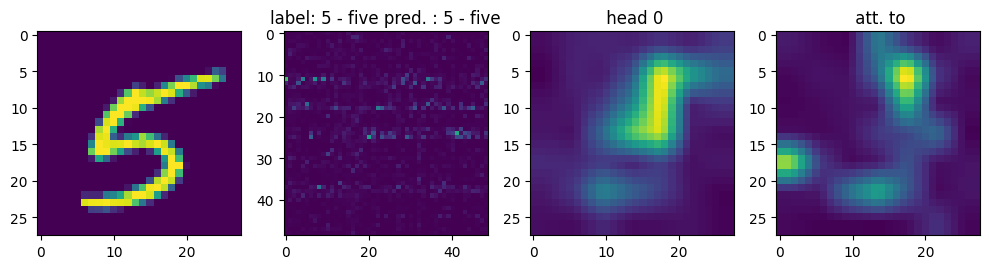

ic| t: 52


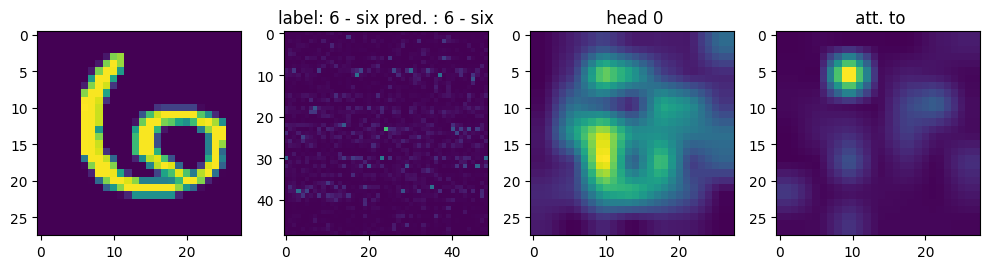

ic| t: 54


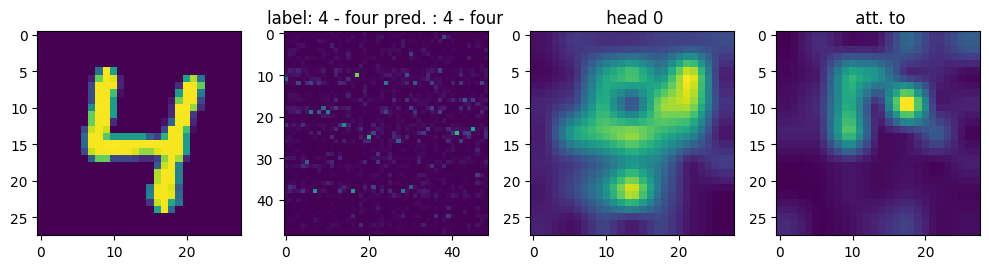

ic| t: 56


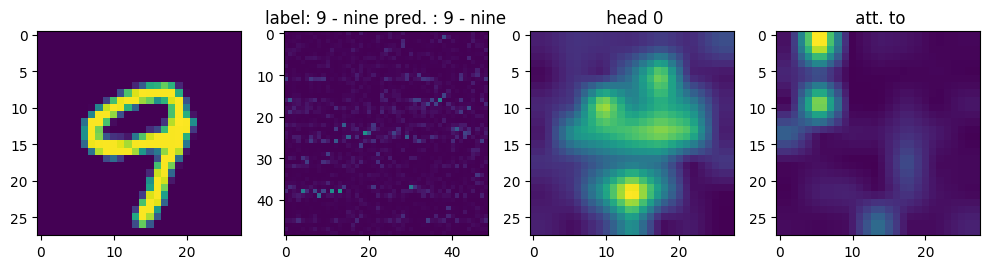

ic| t: 58


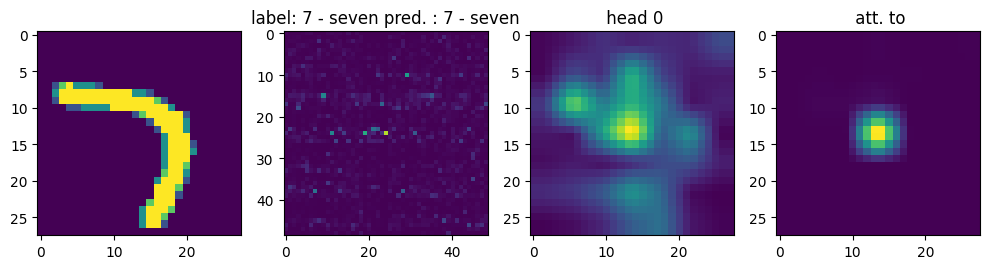

ic| t: 60


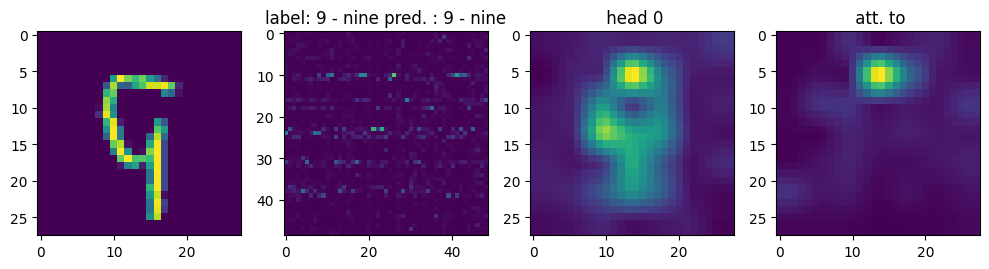

ic| t: 62


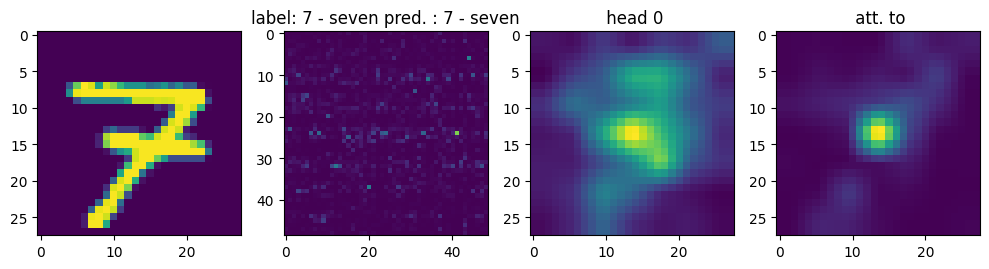

ic| t: 64


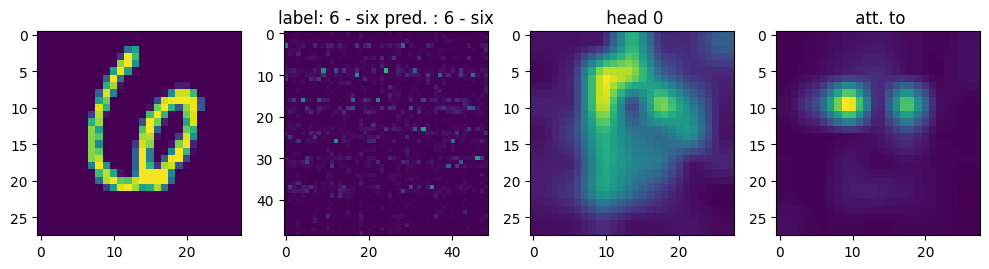

ic| t: 66


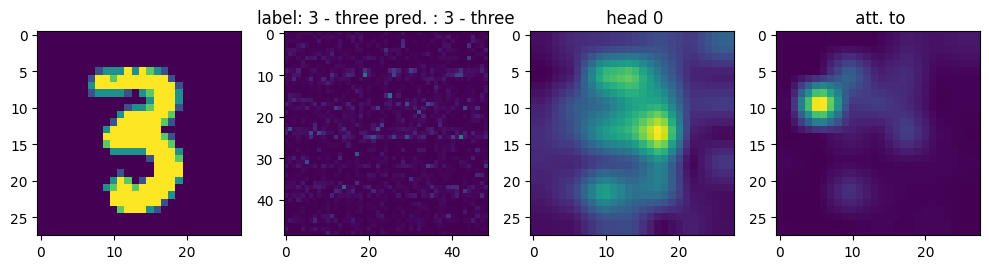

ic| t: 68


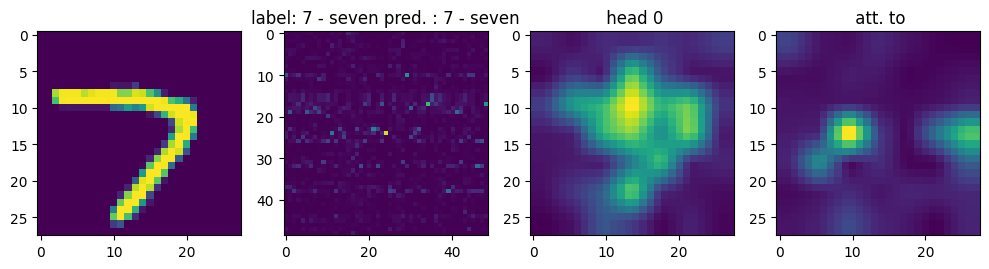

ic| t: 70


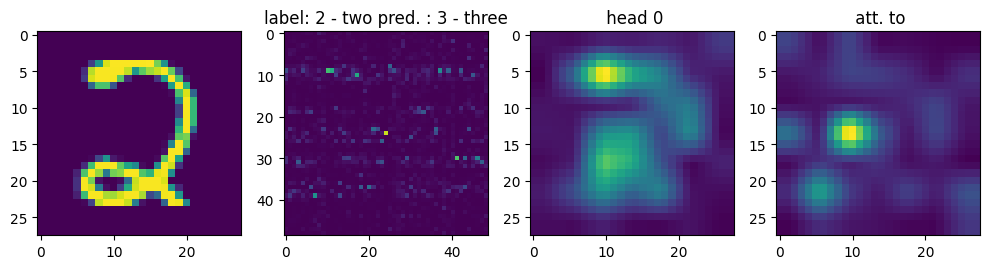

ic| t: 72


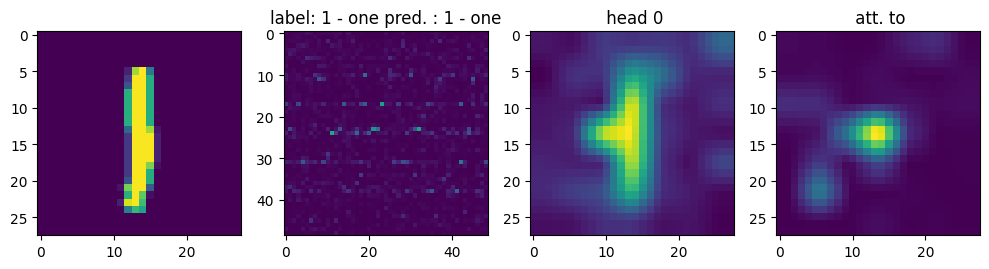

ic| t: 74


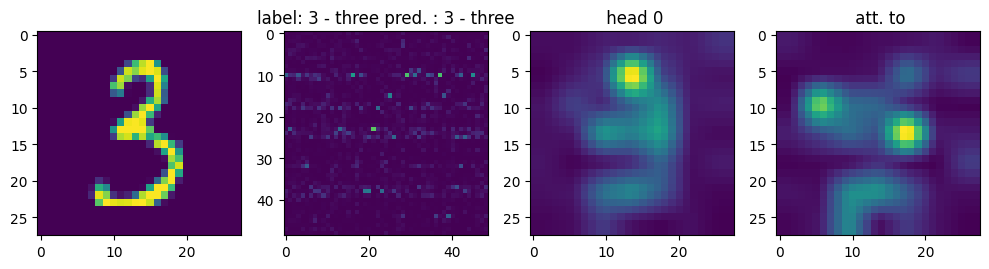

ic| t: 76


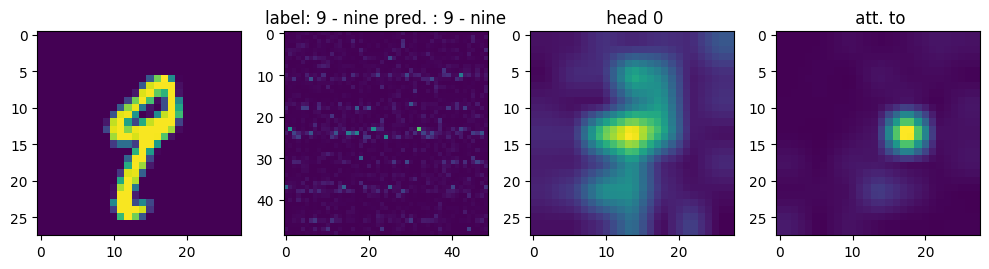

ic| t: 78


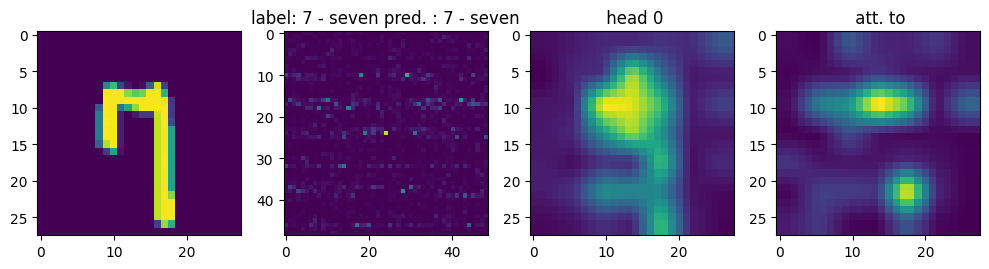

ic| t: 80


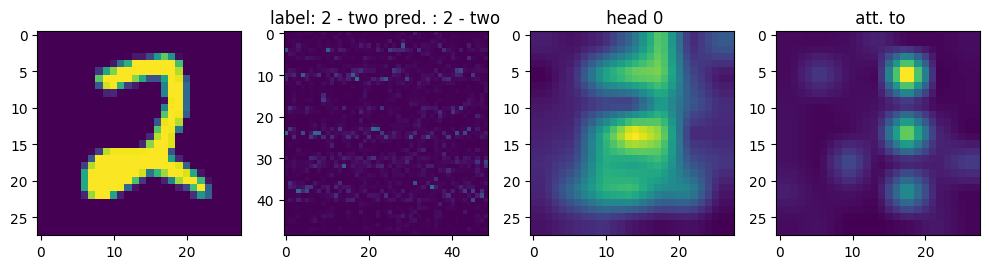

ic| t: 82


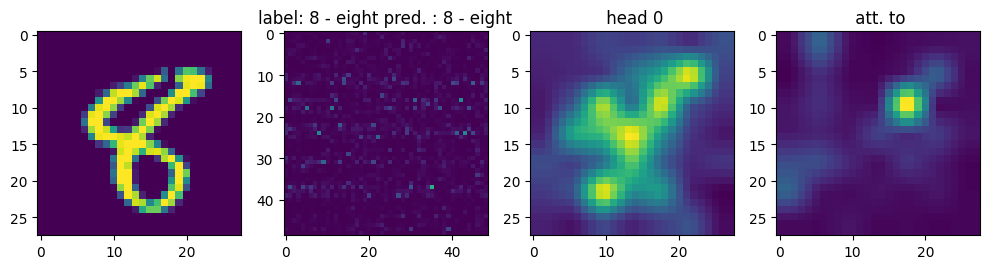

ic| t: 84


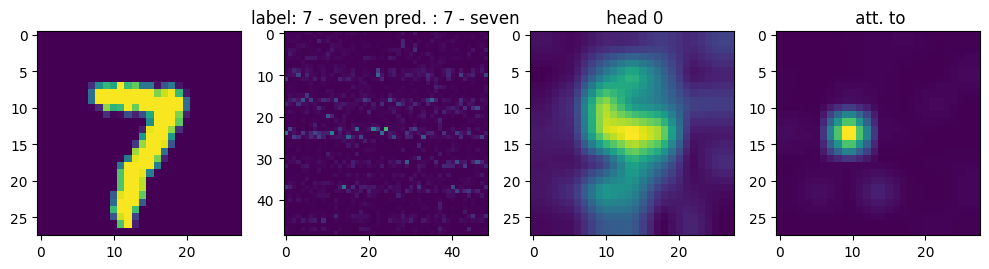

ic| t: 86


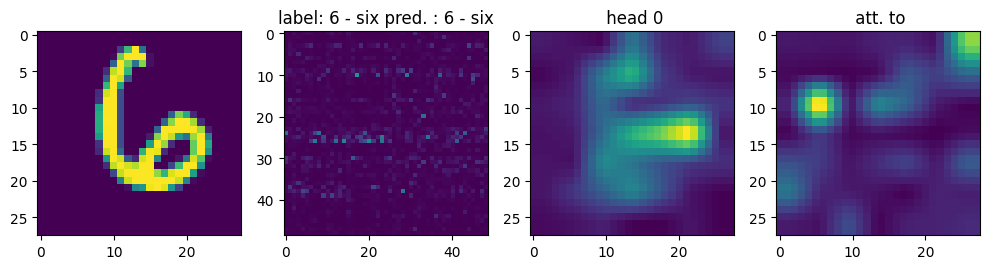

ic| t: 88


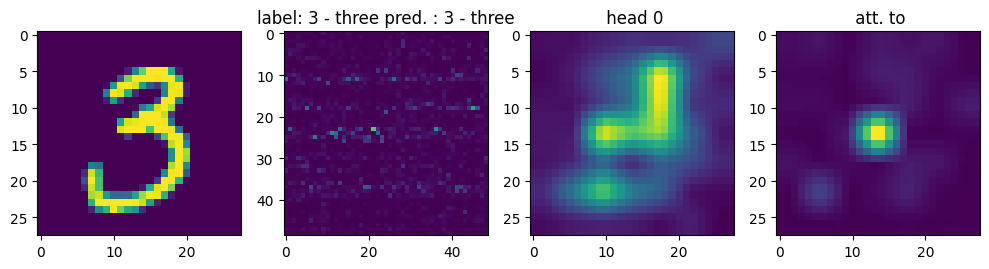

ic| t: 90


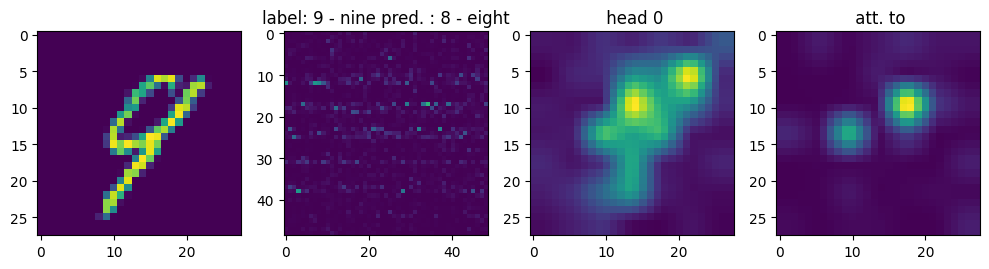

ic| t: 92


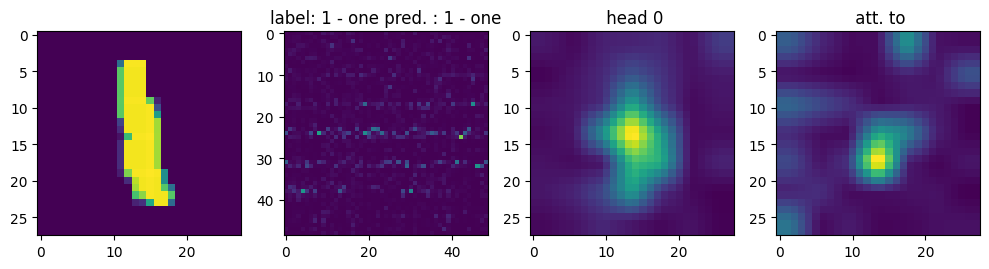

ic| t: 94


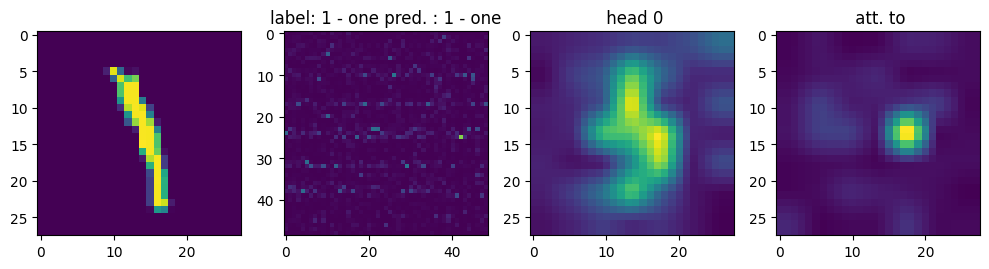

ic| t: 96


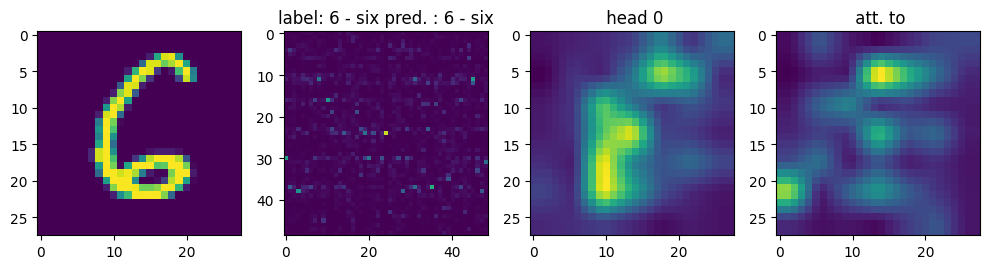

ic| t: 98


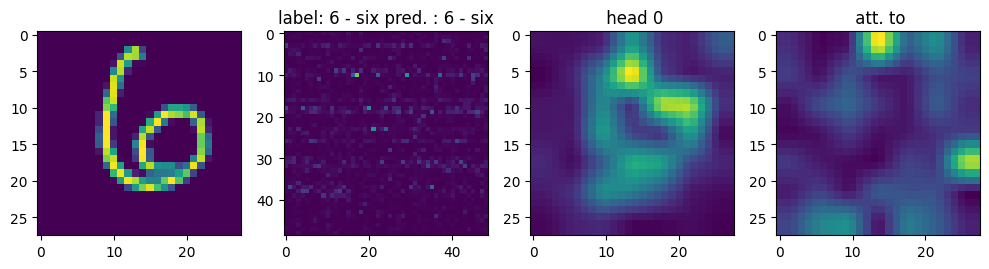

ic| t: 100


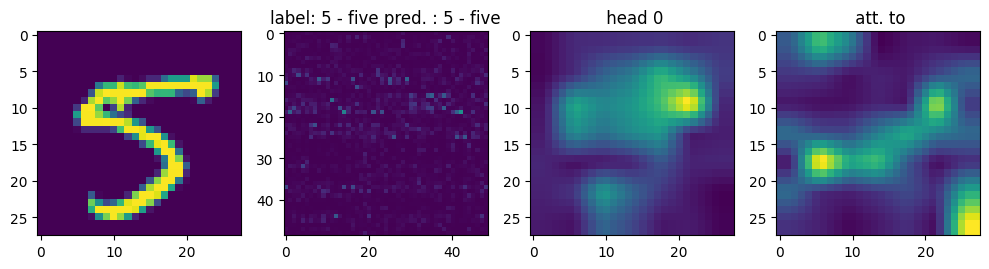

ic| t: 102


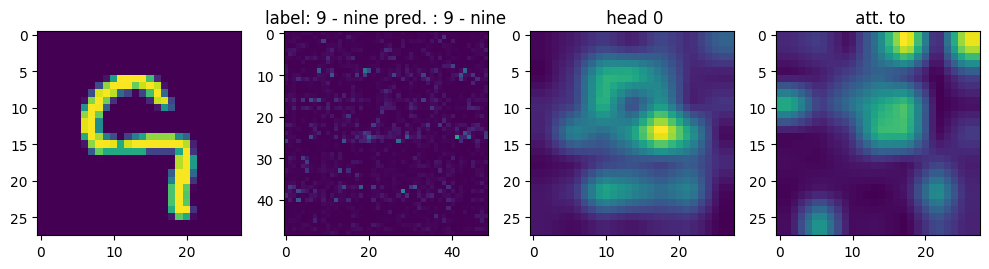

ic| t: 104


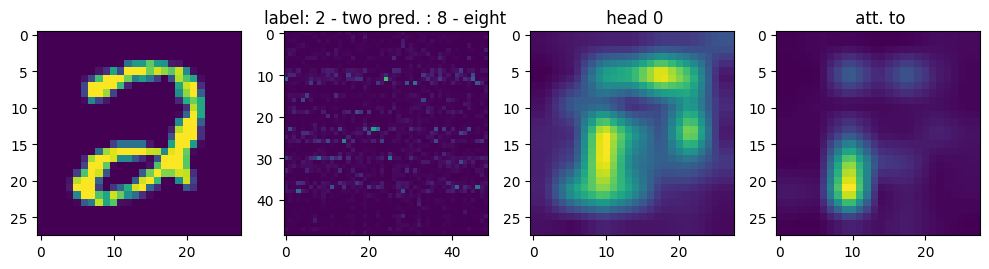

ic| t: 106


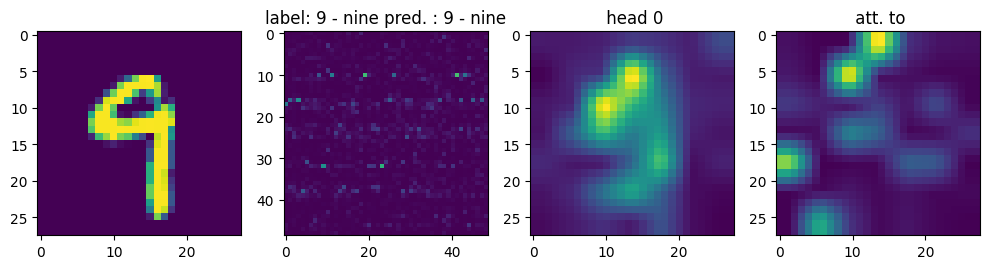

ic| t: 108


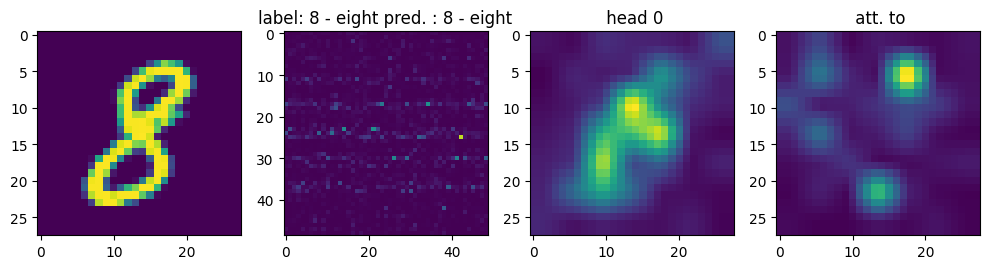

ic| t: 110


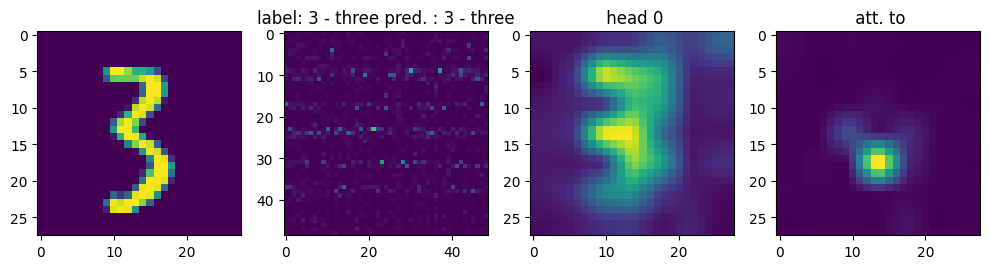

ic| t: 112


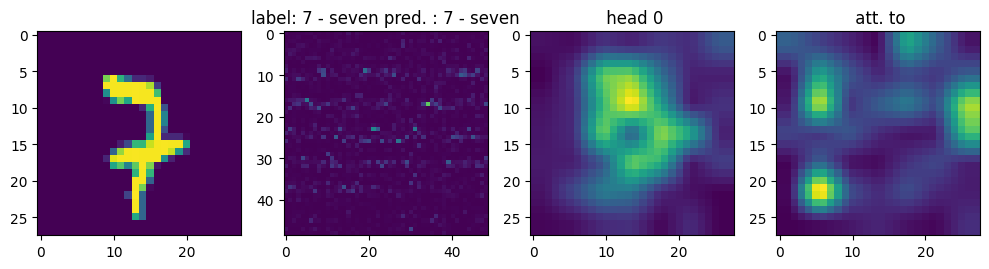

ic| t: 114


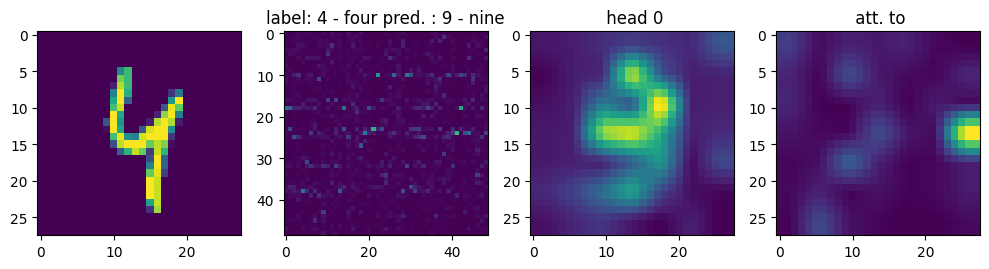

ic| t: 116


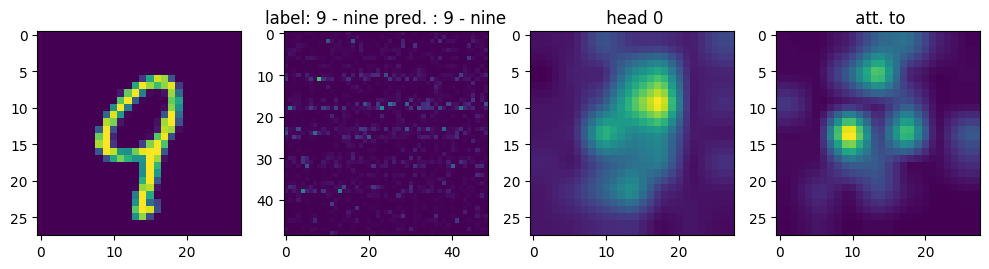

ic| t: 118


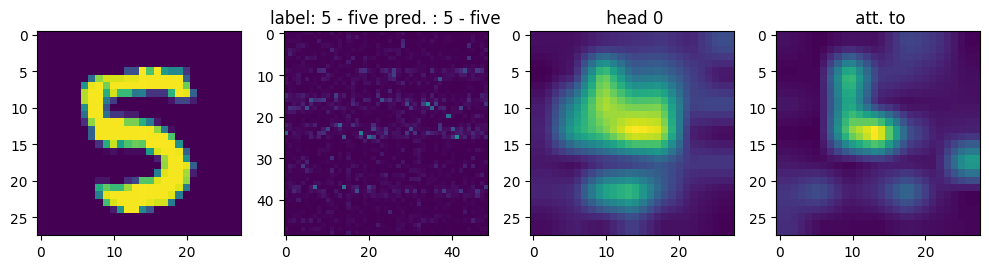

ic| t: 120


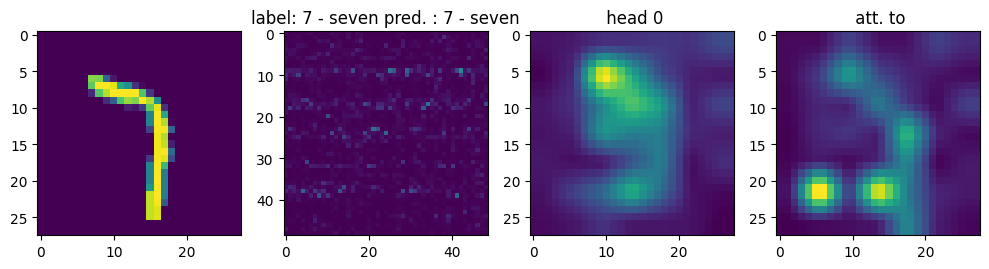

ic| t: 122


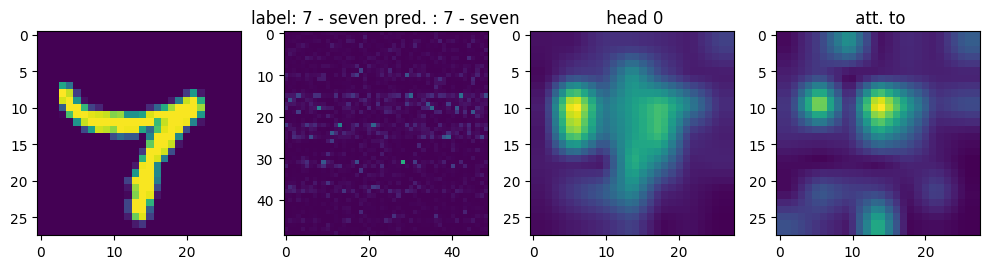

ic| t: 124


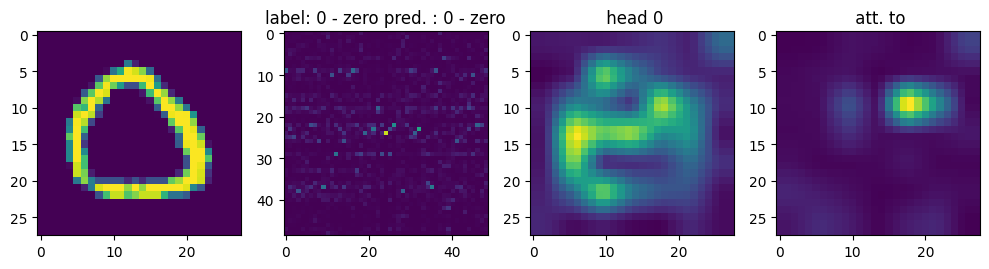

ic| t: 126


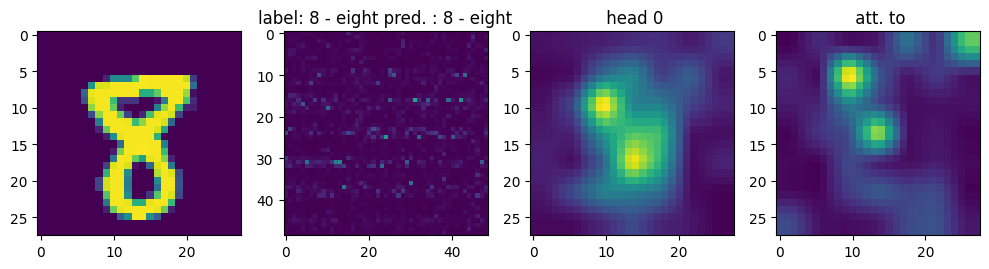

ic| t: 128


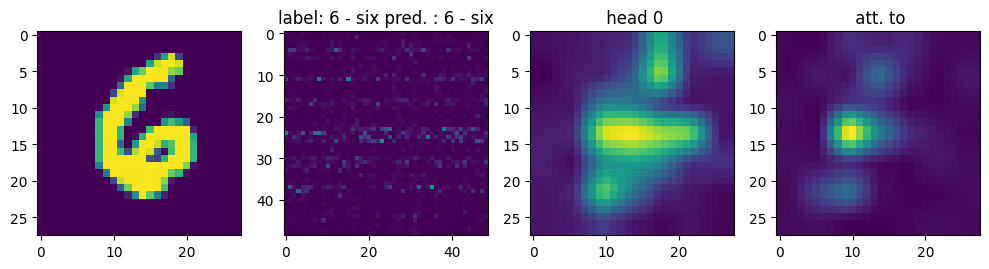

ic| t: 130


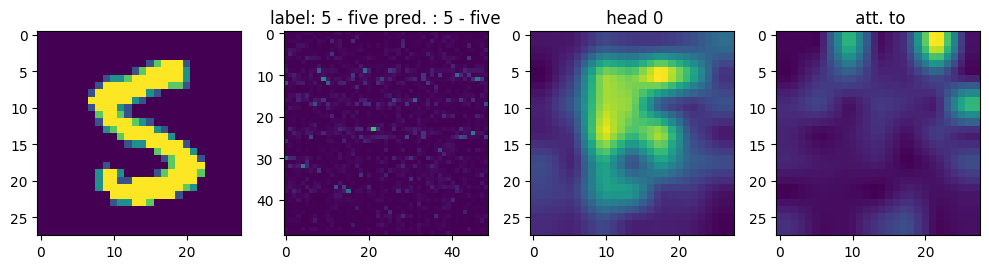

ic| t: 132


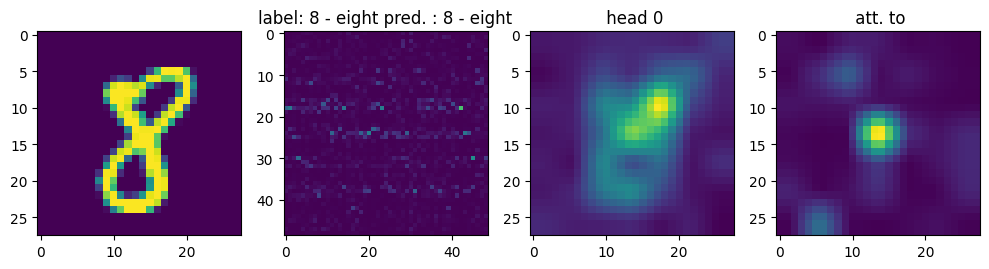

ic| t: 134


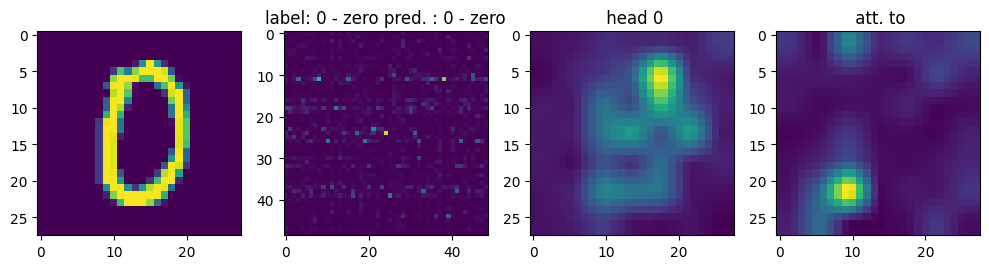

ic| t: 136


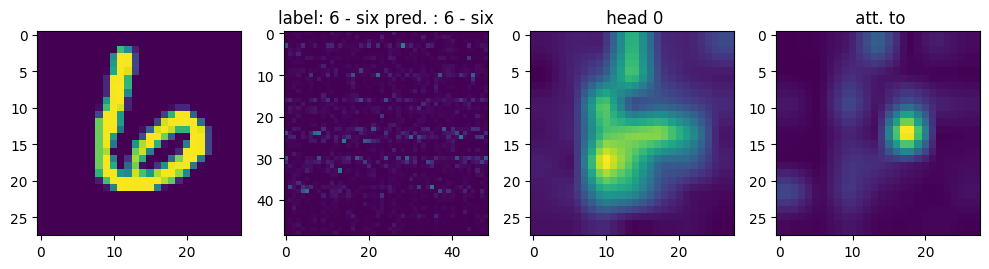

ic| t: 138


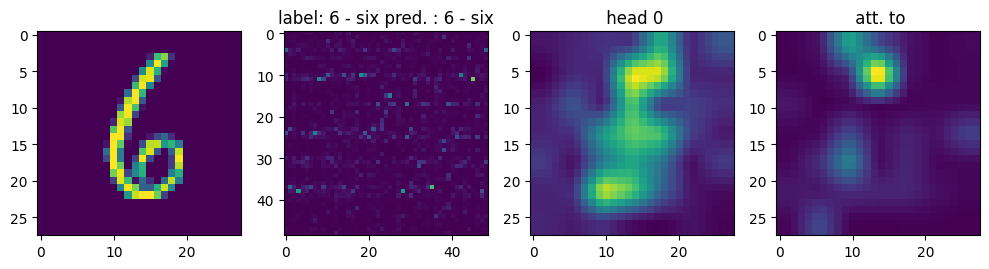

ic| t: 140


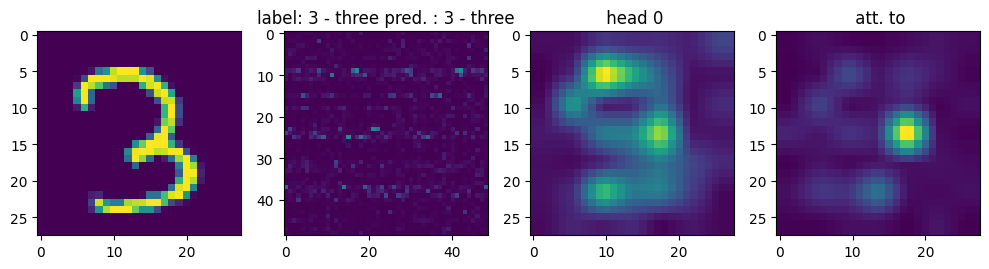

ic| t: 142


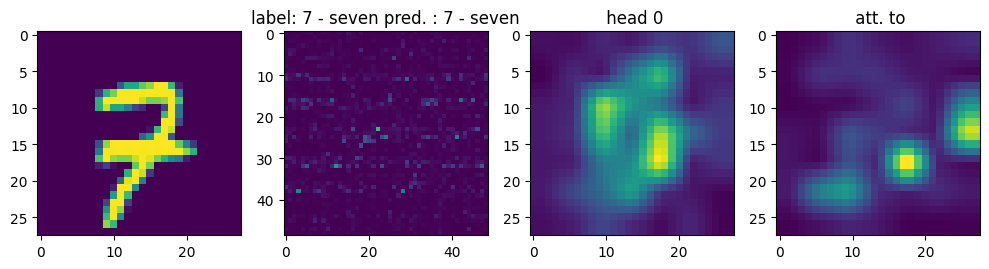

ic| t: 144


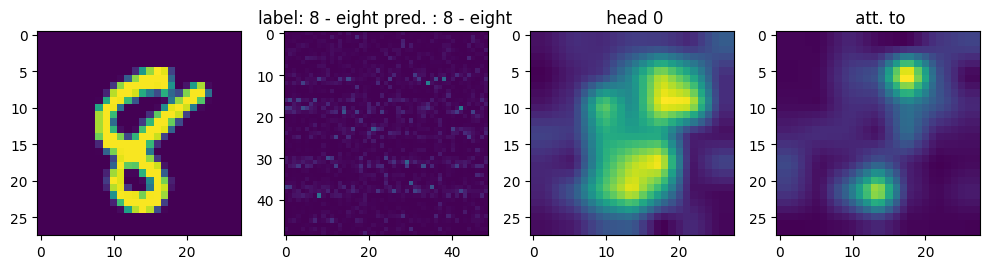

ic| t: 146


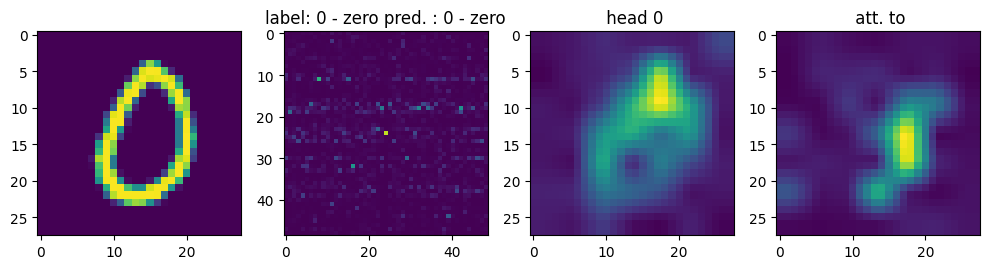

ic| t: 148


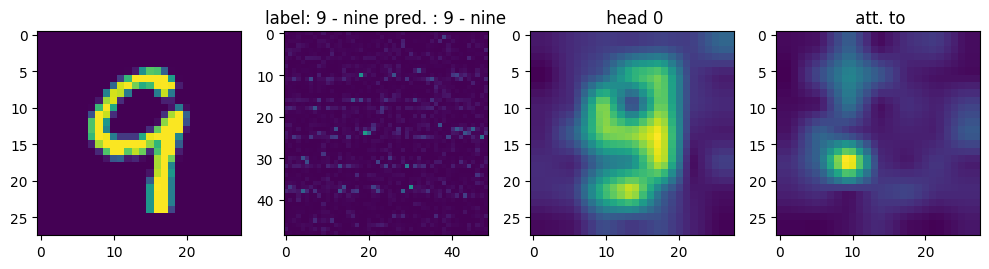

ic| t: 150


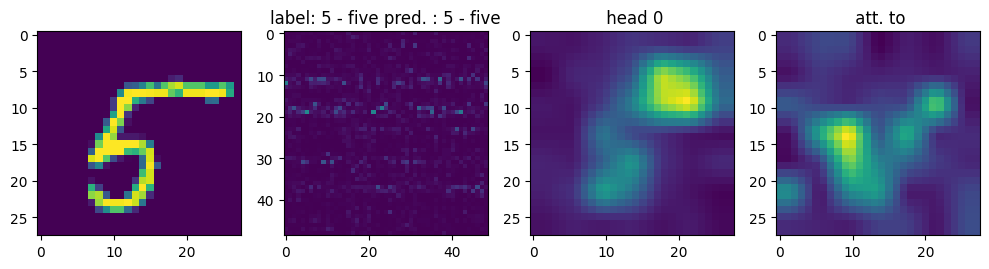

ic| t: 152


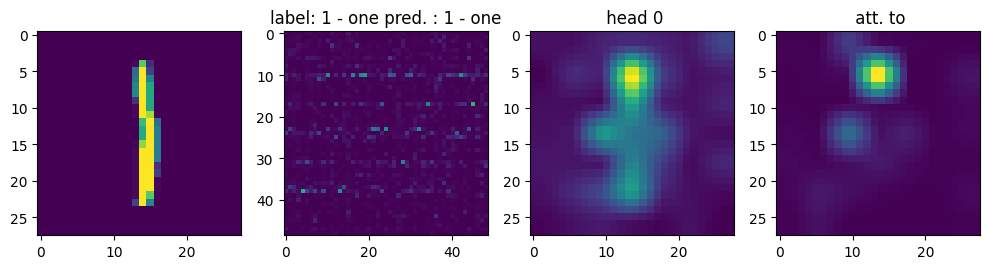

ic| t: 154


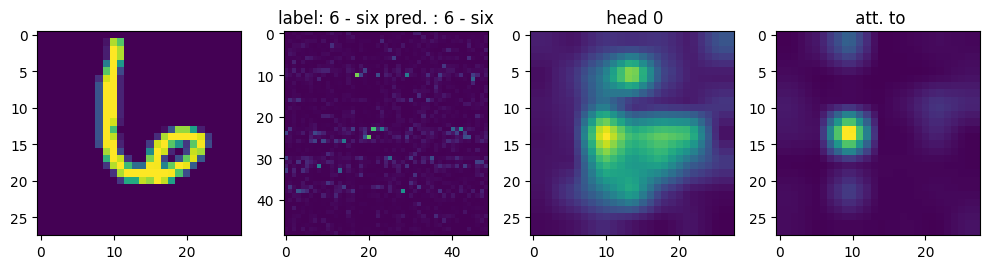

ic| t: 156


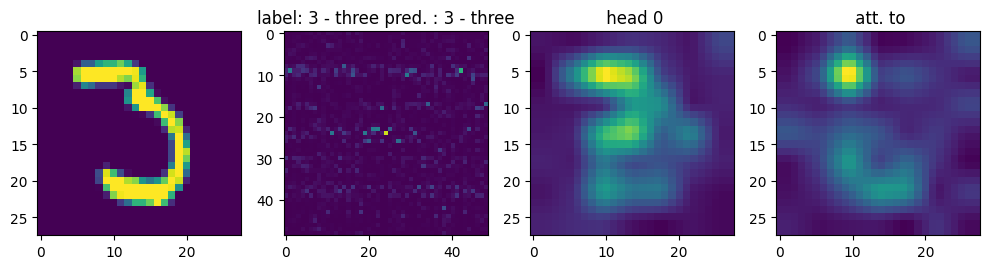

ic| t: 158


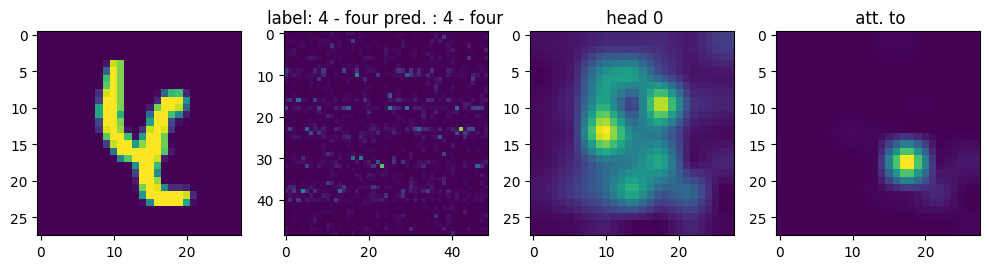

ic| t: 160


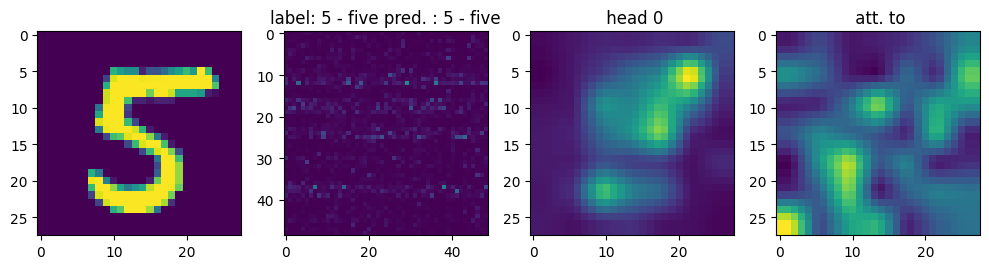

ic| t: 162


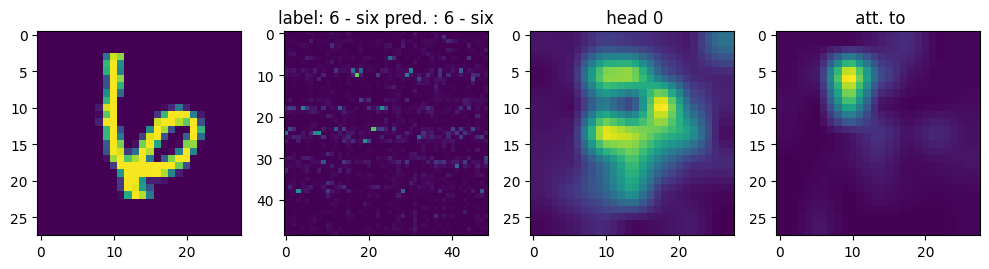

ic| t: 164


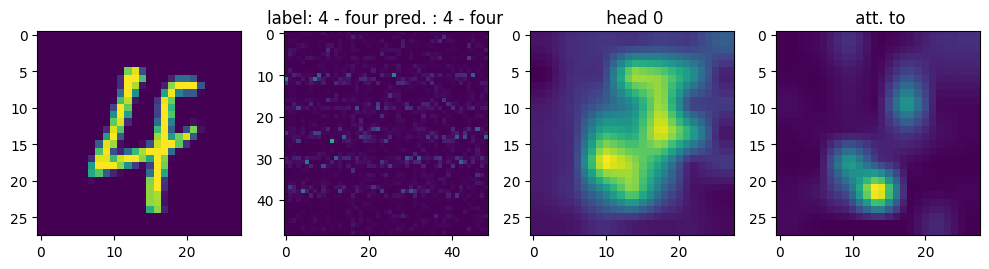

ic| t: 166


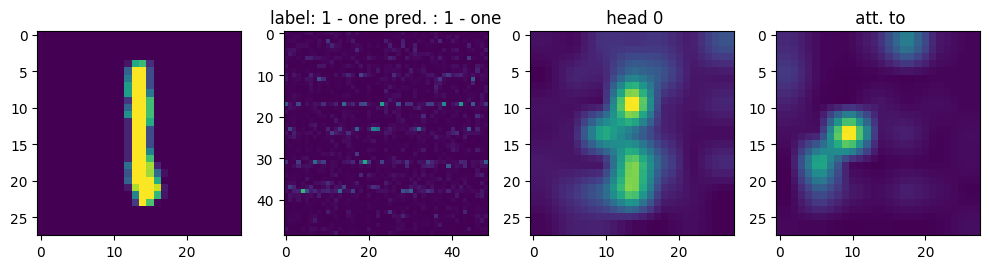

ic| t: 168


In [34]:
for c in range(80):
    
    if True:
        
        if n_head == 1:
            fig, axes = plt.subplots(1,4 , figsize=(10,7))
            axes = axes[None]
        else:
            fig, axes = plt.subplots(n_head,4 , figsize=(10,n_head*3))
        
        
        with torch.no_grad():
            pred0 = model_outputs_test[t*block_size:t*block_size + block_size]
#             pred0.shape
        pred0 = pred0.copy()
        
        # input_array = dmData.get_data().toarray()[t*block_size:t*block_size + block_size]  #/255 -.5
        # print(predicts[:, value_dim: value_dim + 2*embeding_dim].shape)
        # print(np.pad(input_array, [(0,0),(embeding_dim, embeding_dim)], 'reflect') [:,:2*embeding_dim].shape) 
        # train_data = np.pad(input_array, [(0,0),(embeding_dim, 0)], 'reflect') [:,:embeding_dim]
        # if use_input:
        #     pred0[:, value_dim: value_dim + 2*embeding_dim] +=   np.concatenate([train_data,train_data], axis=-1)
        # np.pad(input_array, [(0,0),(embeding_dim, embeding_dim)], 'reflect') [:,:2*embeding_dim]
        # pred0[:, value_dim: value_dim + 2*embeding_dim] +=  np.pad(input_array, 
        #                                                            [(0,0),(embeding_dim, embeding_dim)],
        #                                                            'reflect') [:,:2*embeding_dim]
        pred0 = torch.from_numpy(pred0).float().requires_grad_(False)
        with torch.no_grad():
            values = pred0[:, :value_dim].reshape(-1,block_size,value_dim)
    
            
    
            
            keys = pred0[:, value_dim: value_dim + embeding_dim].reshape(-1,block_size,embeding_dim)
            queries = pred0[:, value_dim + embeding_dim:value_dim + 2*embeding_dim] .reshape(-1,block_size, embeding_dim)
            # keys = pred0[:, value_dim: value_dim + embeding_dim].reshape(-1,block_size,embeding_dim)
            # queries = pred0[:, value_dim + embeding_dim:value_dim + 2*embeding_dim] .reshape(-1,block_size, embeding_dim)
            B, T, C = keys.size()
            
            keys = keys.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
            queries = queries.view(B, T, n_head, C // n_head).transpose(1, 2) # (B, nh, T, hs)
            values = values.view(B, T, n_head, value_dim // n_head).transpose(1, 2) # (B, nh, T, hs)
    
            if False:
                # efficient attention using Flash Attention CUDA kernels
                y = torch.nn.functional.scaled_dot_product_attention(queries, keys, values)
            else:
                # manual implementation of attention
                att = (queries @ keys.transpose(-2, -1)) * (1.0 / np.sqrt(keys.size(-1)))
                # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf')) # causal implementation 
                att = F.softmax(att, dim=-1)
                # att = F.relu(att)
                y = att @ values  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
            output_seq = y.transpose(1, 2).contiguous().view(B, T, value_dim) # re-assemble all head outputs side by side
            output = (output_seq[:,:,:]).sum(1) #
            # ic(F.softmax(output,dim=-1))
            for i, head in enumerate(att[0]):
                axes[i,0].imshow(Testset.data[t])
                
                axes[i,1].imshow(head.T,vmin=0, vmax=1)
                # axes[i,1].imshow(F.relu(head.T),vmin=0)
                # axes[i,1].imshow(head.T)
                tttt = Testset.classes[preds[t]]
                axes[i,1].set_title('label: ' + str(Testset.classes[Testset.targets[t]]) + ' pred. : ' +  tttt )
                # plt.show()

                attention_mask = head.sum(0).reshape(int(block_size**.5),int(block_size**.5)).numpy()
    #             print( att.sum(0))
                image = cv2.resize(attention_mask, (28, 28))
                # ic(image)
                axes[i,2].imshow(image)
                axes[i,2].set_title(f' head {i}')

                index_max = head.sum(0).argmax()
                att_to = head[index_max].reshape(int(block_size**.5),int(block_size**.5)).numpy()
                axes[i,3].imshow(cv2.resize(att_to, (28, 28)))
                axes[i,3].set_title(f' att. to')
        #         axes[2].imshow(attention_mask)
    
        #         axes[2].imshow(att.sum(0).reshape(int(len(tiles)**.5),int(len(tiles)**.5)), interpolation="bicubic")
            fig.tight_layout()   
            plt.show()
    
    ic(t)
    t+=2

In [35]:
# itert = iter(TestLoader)


In [36]:
# index_max = head.sum(0).argmax()
# att_to = head[index_max].reshape(int(block_size**.5),int(block_size**.5)).numpy()

# plt.imshow(cv2.resize(att_to, (28, 28)),vmin=0, vmax=.1)
# plt.show()

In [37]:
head[index_max]

tensor([0.0276, 0.0050, 0.0040, 0.0243, 0.1092, 0.0159, 0.0041, 0.0410, 0.0040,
        0.0009, 0.0018, 0.0018, 0.0031, 0.0033, 0.0200, 0.0018, 0.0010, 0.0156,
        0.0038, 0.0099, 0.0037, 0.0086, 0.0099, 0.2969, 0.0121, 0.0238, 0.0023,
        0.0078, 0.0018, 0.1662, 0.0040, 0.0009, 0.0037, 0.0020, 0.0076, 0.0004,
        0.0658, 0.0185, 0.0068, 0.0222, 0.0113, 0.0015, 0.0052, 0.0042, 0.0004,
        0.0025, 0.0008, 0.0017, 0.0091])